# Jorge Drexler's music and lyrics
## Data exploration

In [520]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from scipy import stats

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from py_lex import EmoLex

import math
from os import path
import re
from collections import Counter

The data in this db was created using [Genius' API](https://genius.com/developers). Check [this notebook](drexler_dataset_builder.ipynb) for the steps taken.

In [196]:
df = pd.read_csv('data/drexler_complete_lyrics.csv', sep=';')
df.sample(10)

,id,lyrics,title,url,album,duplicated,year
50,1030216,Hay una parte de mí que va Camino a La Paloma ...,Camino a La Paloma,https://genius.com/Jorge-drexler-camino-a-la-p...,Frontera,False,1999
80,1002897,"Tu beso se hizo calor Luego el calor, movimien...",Todo se transforma,https://genius.com/Jorge-drexler-todo-se-trans...,Eco,False,2004
125,3204469,Desde lo profundo de los cromosomas De los as...,Mandato,https://genius.com/Jorge-drexler-mandato-lyrics,Salvavidas de hielo,False,2017
87,1483931,No tengo a quien rezarle Pidiendo luz Ando tan...,Hermana Duda,https://genius.com/Jorge-drexler-hermana-duda-...,12 Segundos de Oscuridad,False,2006
64,974515,"Para contarte, canto Quiero que sepas cuánto M...",Me haces bien,https://genius.com/Jorge-drexler-me-haces-bien...,Sea,False,2001
89,1857817,Aquel mensaje que no debió haber leído Aquel b...,La Infidelidad De La Era Informatica,https://genius.com/Jorge-drexler-la-infidelida...,12 Segundos de Oscuridad,False,2006
43,1774973,Yo tengo pintada en la piel A lágrima de esta ...,Montevideo,https://genius.com/Jorge-drexler-montevideo-ly...,Llueve,False,1997
10,1376982,Una bolsa de leche encallada en la arena Un mu...,Cerca del mar,https://genius.com/Jorge-drexler-cerca-del-mar...,Radar,False,1994
131,3154927,Que viva la telefonía En todas sus variantes ...,Telefonía,https://genius.com/Jorge-drexler-telefonia-lyrics,Salvavidas de hielo,False,2017
105,1033827,Estoy aquí de paso Yo soy un pasajero No quier...,Tres Mil Millones de Latidos,https://genius.com/Jorge-drexler-tres-mil-mill...,Amar la trama,False,2010


## Wordcount
Let's start with a simple word count analysis of our lyrics to see if we can get quick insights.

In [197]:
df['words'] = df.lyrics.str.strip().str.split('[\W_]+')

In [198]:
rows = list()
for row in df[['words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((word))

words = pd.DataFrame(rows, columns=['word'])
words.head()

,word
0,El
1,perfume
2,de
3,la
4,sal


Remove empty rows and cases

In [199]:
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

,word
0,el
1,perfume
2,de
3,la
4,sal


Word count per song

In [200]:
counts = words\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
counts

,n_w
de,858
que,689
la,686
el,611
y,559
en,513
no,377
a,338
un,271
tu,269


So, from this we get to know two important _(and completely obvious and unimportant)_ facts:
 - Most used words in Jorge Drexler's songs are 'de', 'que', 'la', 'el' and 'y'......
 - **We need to exclude stopwords**.

In [201]:
stopwords = stopwords.words('spanish')

In [202]:
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)

In [203]:
counts.head(20)

,n_w
na,120
mar,108
tiempo,82
noche,67
luna,63
corazón,57
bailar,53
va,50
si,50
cada,50


**WTF is that 'na' topping the list?**

In [10]:
songs = list()
for row in df[['title','words']].iterrows():
    r = row[1]
    if 'na' in r.words:
        songs.append(r.title)

songs

['Estalactitas']

Now it's pretty obvious, just listen to the song.

_by the way... I love this song_

In [209]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/YFBe7hLUPKo?start=80&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

So, let's get rid of that beautiful sounding "na"

In [213]:
counts = counts.drop('na')

Without any further ado, here are the **top 20 words** used by Jorge Drexler.

In [214]:
counts.head(20)

,n_w
mar,108
tiempo,82
noche,67
luna,63
corazón,57
bailar,53
va,50
si,50
cada,50
dos,49


Let's take that up a notch. Let's check Jorge's top 5 words, use them as themes and see how he has used those themes through time, using his albums as stepping stones.

In [215]:
top_five_words = counts.head(5).index
top_five_words

Index(['mar', 'tiempo', 'noche', 'luna', 'corazón'], dtype='object')

'mar', 'tiempo', 'noche', 'luna' & 'corazón' mean literally and respectively 'sea', 'time', 'night', 'moon' and 'heart'.
Cool stuff to write about, right?

So let's check its counts for each album

In [224]:
words_by_album = {}
words_by_year = {}
for row in df[['album','words','year']].iterrows():
    r = row[1]
    if r.album == 'Others':
        continue
    if r.album not in words_by_album:
        words_by_album[r.album] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    if r.year not in words_by_year:
        words_by_year[r.year] = {
            top_five_words[0]: 0,
            top_five_words[1]: 0,
            top_five_words[2]: 0,
            top_five_words[3]: 0,
            top_five_words[4]: 0
        }
    for a_word in r.words:
        if a_word == top_five_words[0]:
            words_by_album[r.album][top_five_words[0]] += 1
            words_by_year[r.year][top_five_words[0]] += 1
        if a_word == top_five_words[1]:
            words_by_album[r.album][top_five_words[1]] += 1
            words_by_year[r.year][top_five_words[1]] += 1
        if a_word == top_five_words[2]:
            words_by_album[r.album][top_five_words[2]] += 1
            words_by_year[r.year][top_five_words[2]] += 1
        if a_word == top_five_words[3]:
            words_by_album[r.album][top_five_words[3]] += 1
            words_by_year[r.year][top_five_words[3]] += 1
        if a_word == top_five_words[4]:
            words_by_album[r.album][top_five_words[4]] += 1
            words_by_year[r.year][top_five_words[4]] += 1

In [225]:
ROWS = 4
COLS = 3
max_appearance = 0
for album in words_by_album:
    for word in words_by_album[album]:
        a_number = words_by_album[album][word]
        if a_number > max_appearance:
            max_appearance = a_number

albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 Segundos de Oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

colormap = {
    'mar': 'xkcd:royal blue',
    'tiempo': 'xkcd:mustard',
    'luna': 'grey',
    'noche': 'black',
    'corazón': 'xkcd:crimson' 
}

def autolabel(rects, x, y):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axes[x,y].text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')


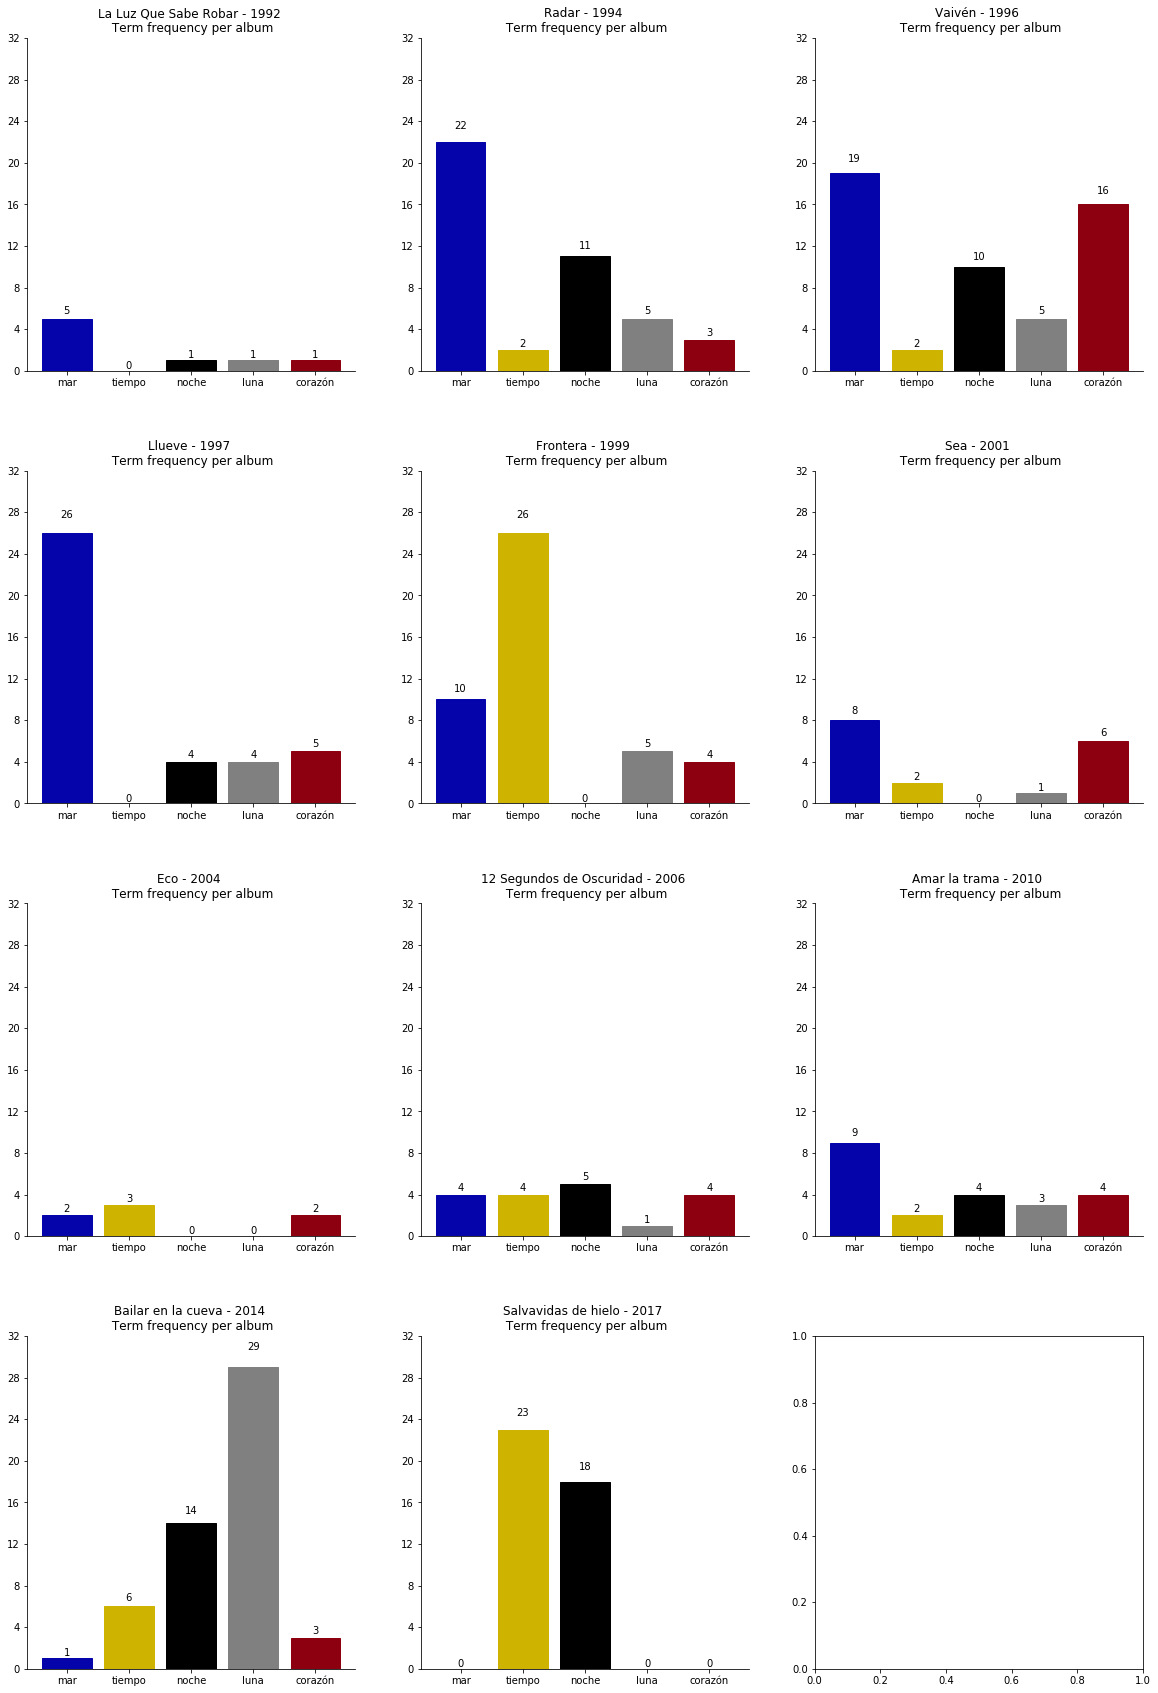

In [226]:
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))

for row in range(ROWS):
    for col in range(COLS):
        if not albums_ordered_by_year:
            break
            
        an_album_title = albums_ordered_by_year.pop(0)
        an_album_year = years_for_albums.pop(0)
        an_album = words_by_album[an_album_title]
        rects = axes[row, col].bar(range(len(an_album)), list(an_album.values()), align='center')
        axes[row, col].set_xticks(range(len(an_album)))
        axes[row, col].set_xticklabels(list(an_album.keys()))
        axes[row, col].yaxis.set_major_locator(MaxNLocator(integer=True))
        axes[row, col].set_ylim([0,max_appearance + 3])
        axes[row, col].set_title("%s - %d \n Term frequency per album" % (an_album_title, an_album_year))
        axes[row, col].spines['right'].set_visible(False)
        axes[row, col].spines['top'].set_visible(False)
        rects[0].set_color('xkcd:royal blue')
        rects[1].set_color('xkcd:mustard')
        rects[2].set_color('black')
        rects[3].set_color('grey')
        rects[4].set_color('xkcd:crimson')
        autolabel(rects, row, col)

plt.subplots_adjust(hspace = 0.3)
plt.show()

### Come look! Interesting insight!
    - He loved talking about the sea ('mar') in the 90's but grew bored as time passed by.
    - In Vaivén (1996), the heart ('corazón') appears as a practically new theme. It never recovers the lead afterwards. Also the night ('noche') is present. Could this be a heartbreak records?
    - After a time in his albums, practically the first decade of the millenium, where he doesn't revisit his favorite terms a lot, comes back to monothematic stuff.
    - Bailar en la cueva (2014) is super focused on the moon ('luna') and the night ('noche').
    - Salvavidas de hielo (2017) is about the pass of time ('tiempo'), a trend which he recovered from Frontera (1999), and again, the night ('noche').

Let's change the visualization technique to contemplate also the pass of time in each theme.

In [227]:
words_by_year = pd.DataFrame(words_by_year).transpose()

In [228]:
values_for_y_ticks = []
for a_word in words_by_year.columns:
    values_for_y_ticks.extend(words_by_year[a_word].unique())
values_for_y_ticks = list(set(values_for_y_ticks))

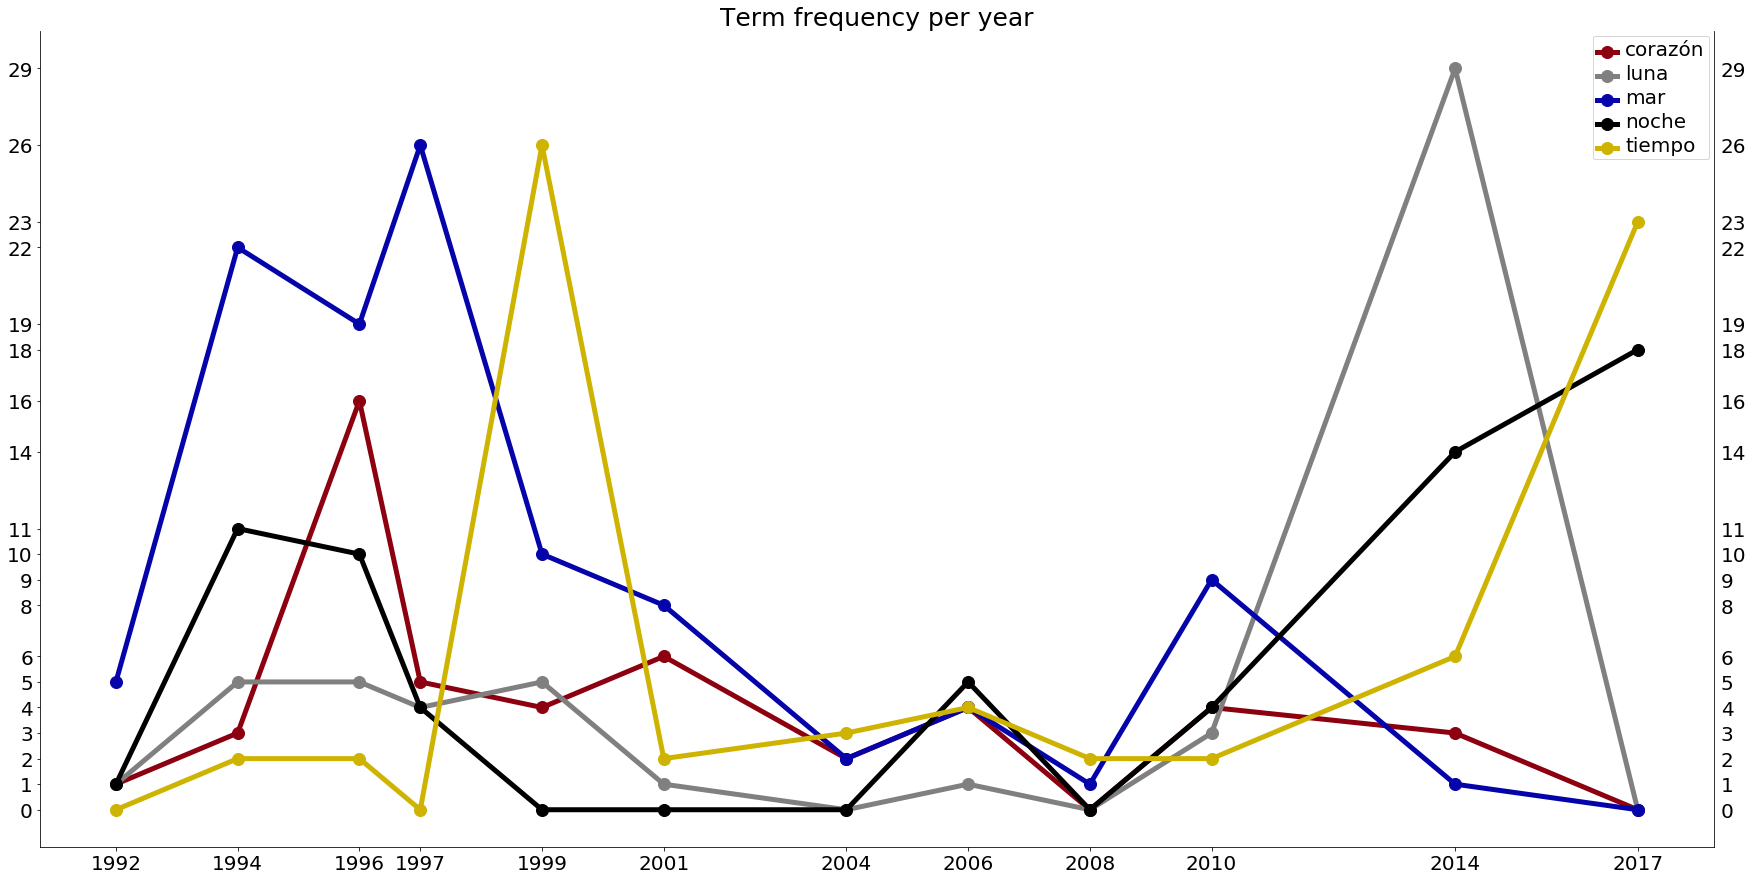

In [229]:
fig, ax = plt.subplots(figsize=(30,15))
for top_word in list(words_by_year.columns):
    ax.plot(
        words_by_year.index, 
        words_by_year[top_word], 
        '-', 
        color=colormap[top_word], 
        linewidth=5, 
        marker='o',
        markersize=12
    )
leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(5)
# get label texts inside legend and set font size
for text in leg.get_texts():
    text.set_fontsize(20)
plt.xticks(words_by_year.index)
plt.yticks(values_for_y_ticks)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Term frequency per year", fontdict={'fontsize': 25})
plt.show()

- In this graph we can actually see the valley in which his most popular themes fall during the 00's.
- The moon ('luna') achieves an all time high in "Bailar en la cueva" (2014).
- Time ('tiempo') peaks in Frontera (1999), sea ('mar') in Llueve (1997) and the night ('noche') in his last album "Salvavidas de Hielo" (2017).

Let's bring to use the data I got from [Spotify API](https://developer.spotify.com/documentation/web-api/). Check [this notebook](drexler_dataset_builder.ipynb) for the steps taken.

In [231]:
df = pd.read_csv("data/drexler_final.csv", sep=';',index_col=0)

In [232]:
df.head()

,track_number,name,album,year,duplicated,duration_ms,duration_s,acousticness,danceability,energy,key,tempo,time_signature,valence,mode,lyrics
index,,,,,,,,,,,,,,,,
0,1,Movimiento,Salvavidas de hielo,2017,False,231653,23.165.333,0.900,0.784,0.457,2.0,125.021,4.0,0.546,1.0,Apenas nos pusimos en dos pies Comenzamos a mi...
1,2,Telefonía,Salvavidas de hielo,2017,False,184963,18.496.354,0.829,0.915,0.592,6.0,126.060,4.0,0.841,0.0,Que viva la telefonía En todas sus variantes P...
2,3,Silencio,Salvavidas de hielo,2017,False,207986,20.798.667,0.263,0.887,0.568,4.0,127.923,4.0,0.127,0.0,Todo el mundo intentando venderte algo Intenta...
3,4,Pongamos que hablo de Martínez,Salvavidas de hielo,2017,False,182453,18.245.333,0.893,0.849,0.458,9.0,119.950,4.0,0.461,1.0,"Fuimos cerrando, uno a uno cuatro bares Montev..."
4,5,Estalactitas,Salvavidas de hielo,2017,False,261066,26.106.667,0.797,0.772,0.630,0.0,136.019,4.0,0.909,1.0,El tiempo era entonces dinamita Vivíamos colga...


In [233]:
df['duration_s'] = df['duration_ms'] * 0.001
df['name'] = df['name'].str.replace(" \(feat.*$", "")

Let's bring back the word count angle for a moment. Let's see how many words his songs have and how this variable is distributed in his albums

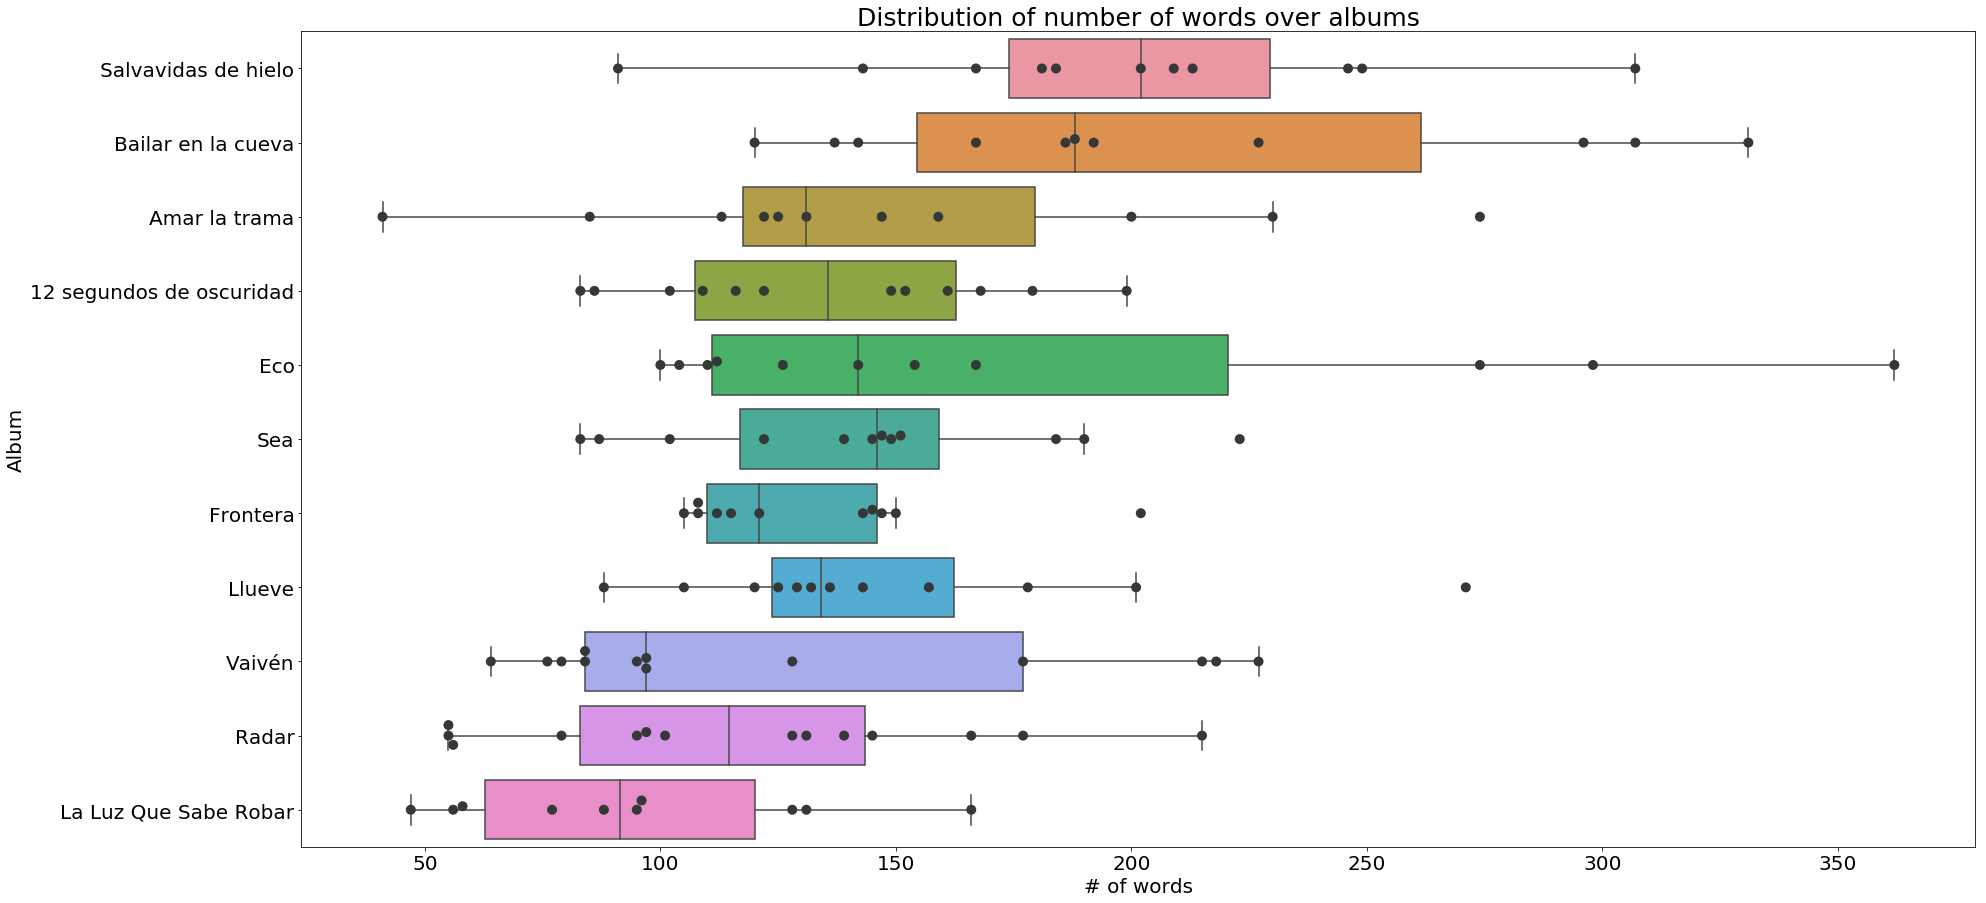

In [235]:
amount_of_words = df.lyrics.str.split().str.len()

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x=amount_of_words, y="album", data=df, orient='h')
ax = sns.swarmplot(x=amount_of_words, y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('# of words', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of number of words over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

Some pretty interesting insight can we seen here.
- There's a more than clear trend of growth over time. __The mean number of words increases with the years__.
- Eco is by far the album with more variance, and it also poseses the Drexler song with more words: "Guitarra y vos"

Let's calculate some more stats to check just from the lyrics. We'll get to explanations later.

In [310]:
stopset = set(stopwords)
df['tokens'] = pd.Series(dtype=object)
for index, row in df.iterrows():
    try:
        tokens = word_tokenize(row['lyrics'])
        tokens_wo_stopwords = [word for word in tokens if not word in stopset]
        df.at[index, 'tokens'] = tokens_wo_stopwords
        df.at[index, 'le_d'] = ( len(tokens_wo_stopwords) / len(tokens) ) * 100
        df.at[index, 'ly_d'] = len(tokens) / row['duration_s']
        df.at[index, 'n_words'] = len(tokens)
        df.at[index, 'n_words_no_rep'] = len(list(set(tokens)))
    except: # songs without lyrics throw exceptions, i'm lazy
        continue

df['le_d'] = df['le_d'].fillna(0)
df['ly_d'] = df['ly_d'].fillna(0)

So, let's change the view on amount of words through time just to recheck our theory.

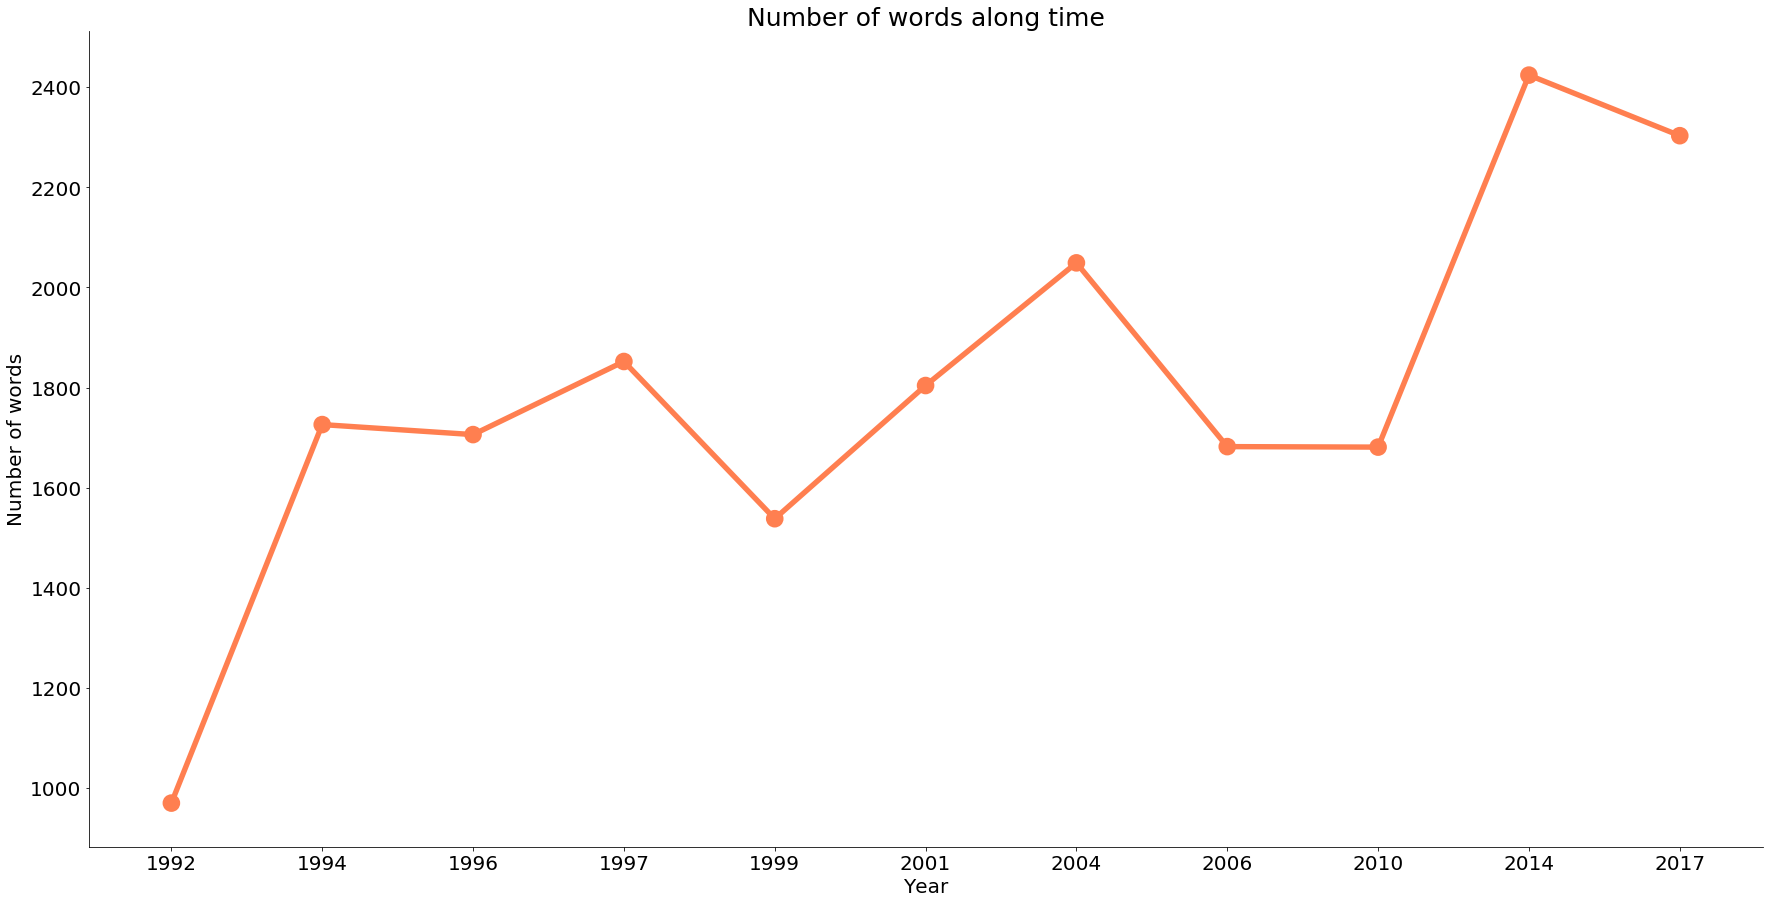

In [311]:
fig, ax = plt.subplots(figsize=(30,15))
n_words_by_album = df.groupby(["year"])['n_words'].sum()
ax = sns.pointplot(x=n_words_by_album.index, y=n_words_by_album, color="coral", scale=2)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of words', fontsize=20)
plt.title('Number of words along time', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
sns.despine()
plt.plot();

Indeed there's a clear trend of including more and more words on his lyrics with time.

How about the amount of words per song? Let's look at top songs with more words and top songs with less words.

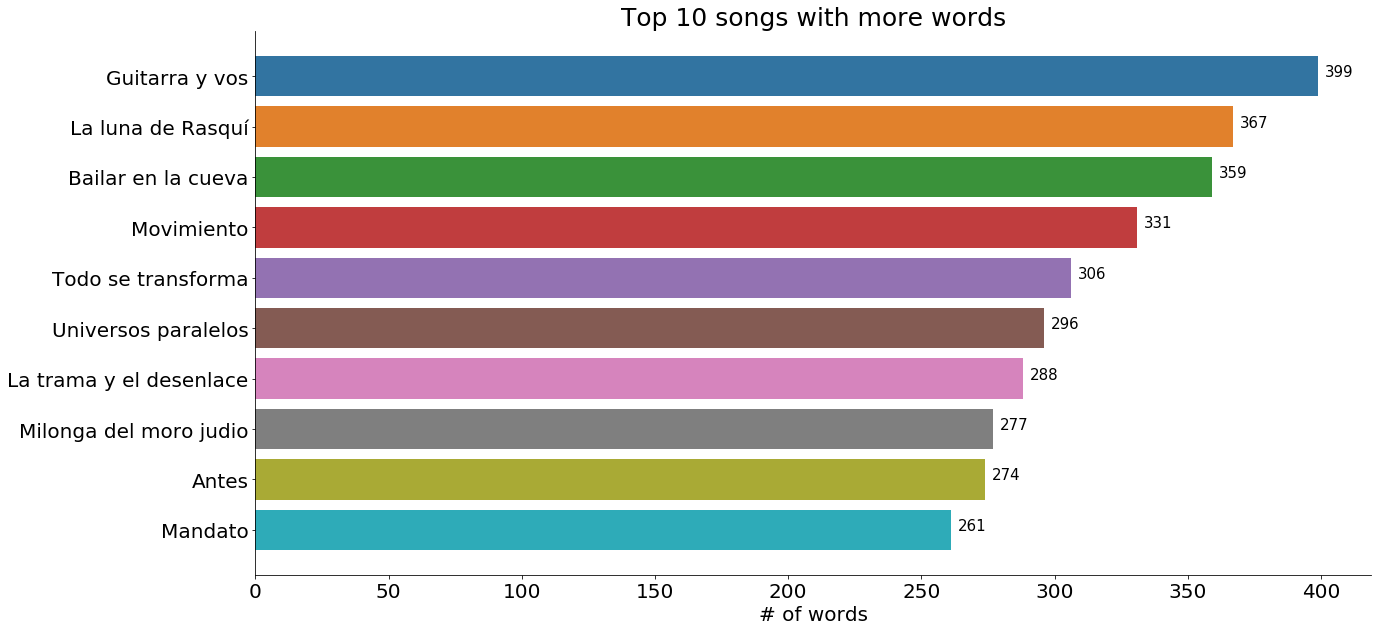

In [312]:
songs_with_more_words = df.sort_values("n_words", ascending=False)[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_more_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with more words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 8  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

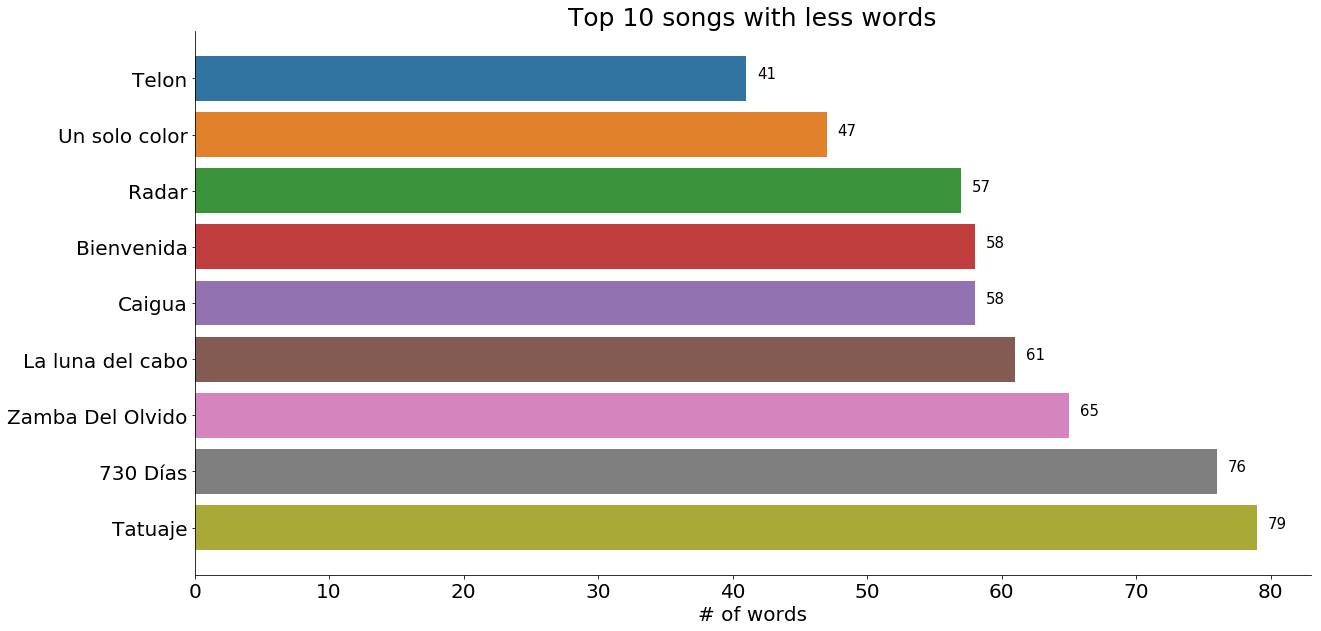

In [313]:
songs_with_less_words = df.sort_values("n_words")[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="n_words", y="name", data=songs_with_less_words)
plt.ylabel("")
plt.xlabel('# of words', fontsize=20)
plt.title('Top 10 songs with less words', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1.5  ,
            p.get_y() + p.get_height()/2.,
            "%d" % width,
            ha="center", fontsize=15)
sns.despine()
plt.plot();

So, 
- **Guitarra y vos**, **La luna de Rasquí** & **Bailar en la cueva** are his songs with more number of lyrics.
- **Telón**, **Un solo color** & **Radar** are his songs with less.

Let's make a pretty wordcloud before leaving the word count subject and move to something more juicy.

In [314]:
stopset.add('na')
def make_corpora(a_series):
    corpora = []
    for a_sentence in a_series:
        try:
            new_lower_sentence = []
            for a_word in a_sentence:
                new_lower_sentence.append(a_word.lower())
            corpora.extend(new_lower_sentence)
        except:
            continue
    nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
    filtered = [w for w in corpora if nonPunct.match(w) and w not in stopset]
    counts = Counter(filtered)
    return counts
drexler_counts = make_corpora(df.tokens)

In [315]:
def plot_wordcloud_from_list(a_list):
    freqs_by_words = {}
    for a_topic_term in a_list:
        an_actual_word = a_topic_term[0]
        freqs_by_words[an_actual_word] = a_topic_term[1]
    # read the mask image
    trump_mask = np.array(Image.open("heart.jpg"))

    wc = WordCloud(background_color="white", max_words=2000, mask=trump_mask, max_font_size=100,)
    # generate word cloud
    wc.generate_from_frequencies(freqs_by_words)

    #show
    plt.figure(figsize=(15,15))
    plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    plt.show()

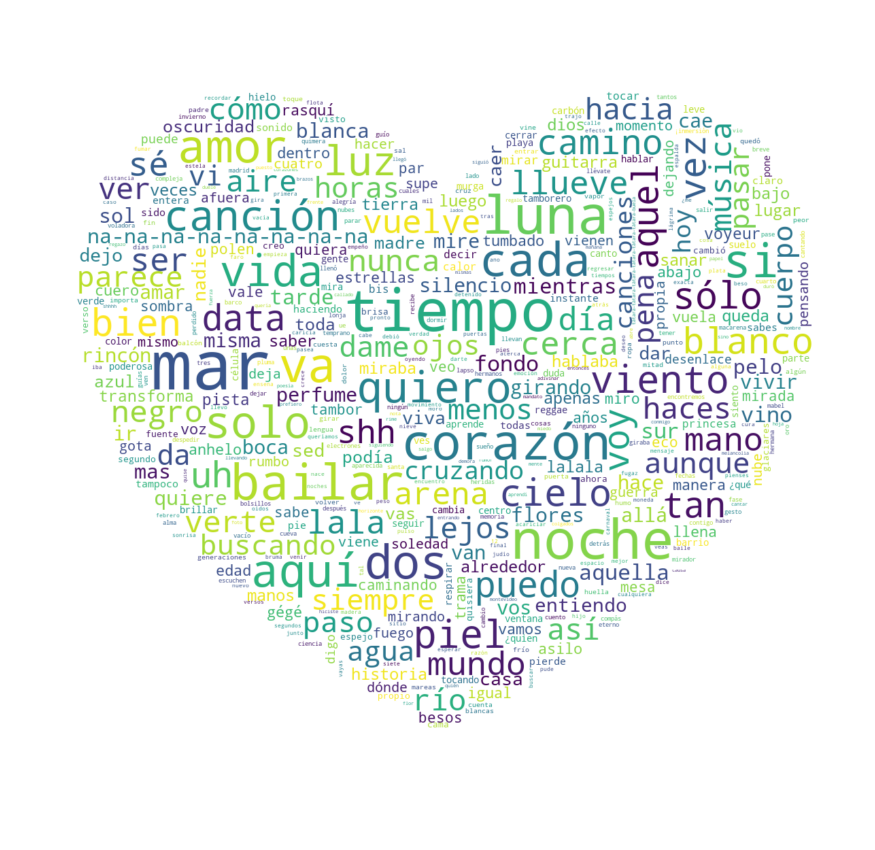

In [316]:
plot_wordcloud_from_list(drexler_counts.most_common(500))

## Lexical Density

In the realm of content analysis there is a measure known as lexical density which is a measure of the number of content words as a proportion of the total number of words - a value which ranges from 0 to 100. In general, the greater the lexical density of a text, the more content heavy it is and more 'unpacking' it takes to understand - texts with low lexical density are easier to understand.

According to Wikipedia the formula is as follows:

$$ Ld = \frac{Nlex}{N} * 100$$

where Ld is the analysed text's lexical density, Nlex is the number of lexical word tokens (nouns, adjectives, verbs, adverbs) in the analysed text, and N is the number of all tokens (total number of words) in the analysed text.

I don't know how ortodox this is, but basing myself on [Myles Harrison's amazing data analysis on Radiohead](http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html), it sounds like this is just the ratio of words which are not stopwords to the total number - or could at least be approximated by it. This calculations steps are fairly simple to follow in pandas.

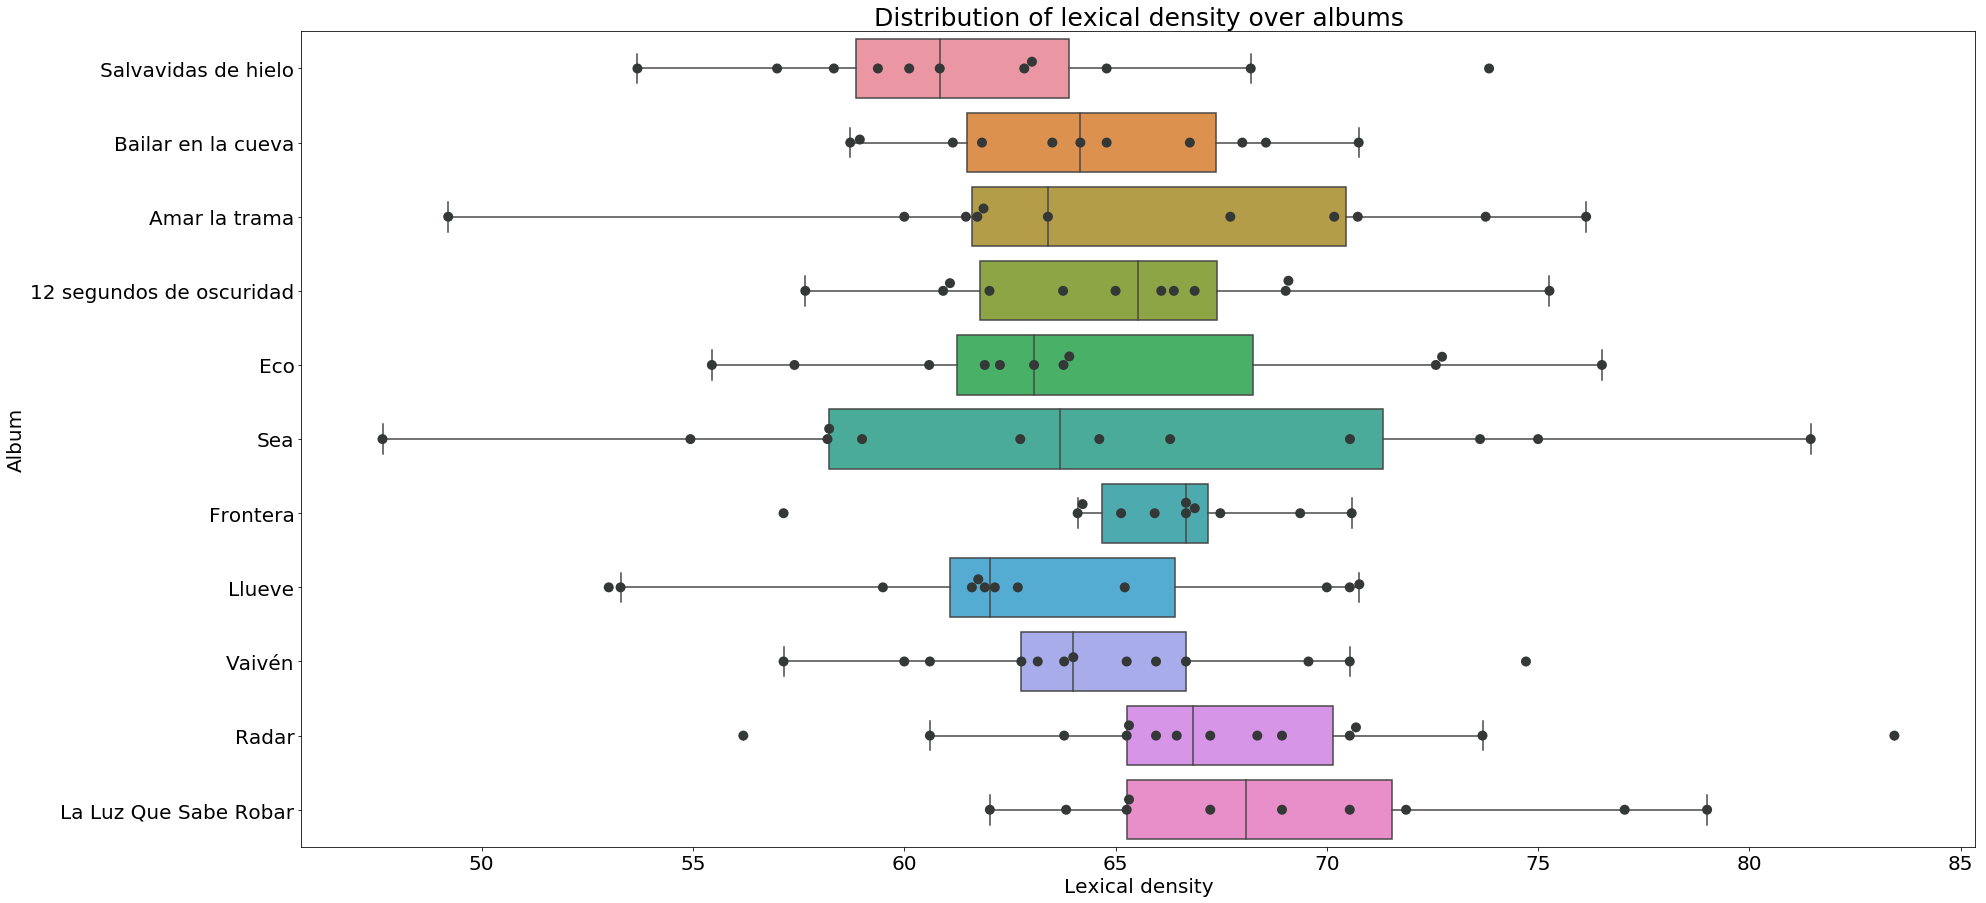

In [324]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="le_d", y="album", data=df[df['le_d'] > 0], orient='h')
ax = sns.swarmplot(x="le_d", y="album", data=df[df['le_d'] > 0], orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lexical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lexical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

So, check this out! Big tendency to decrease with time. Lexical density actually goes down from La luz que sabe robar to Salvavidas de hielo.
Frontera seems to be a pretty consistent album in terms of lexical density, while Sea is all over the place.

We can also check how lexical density is distributed along all songs and not just clustered by album.

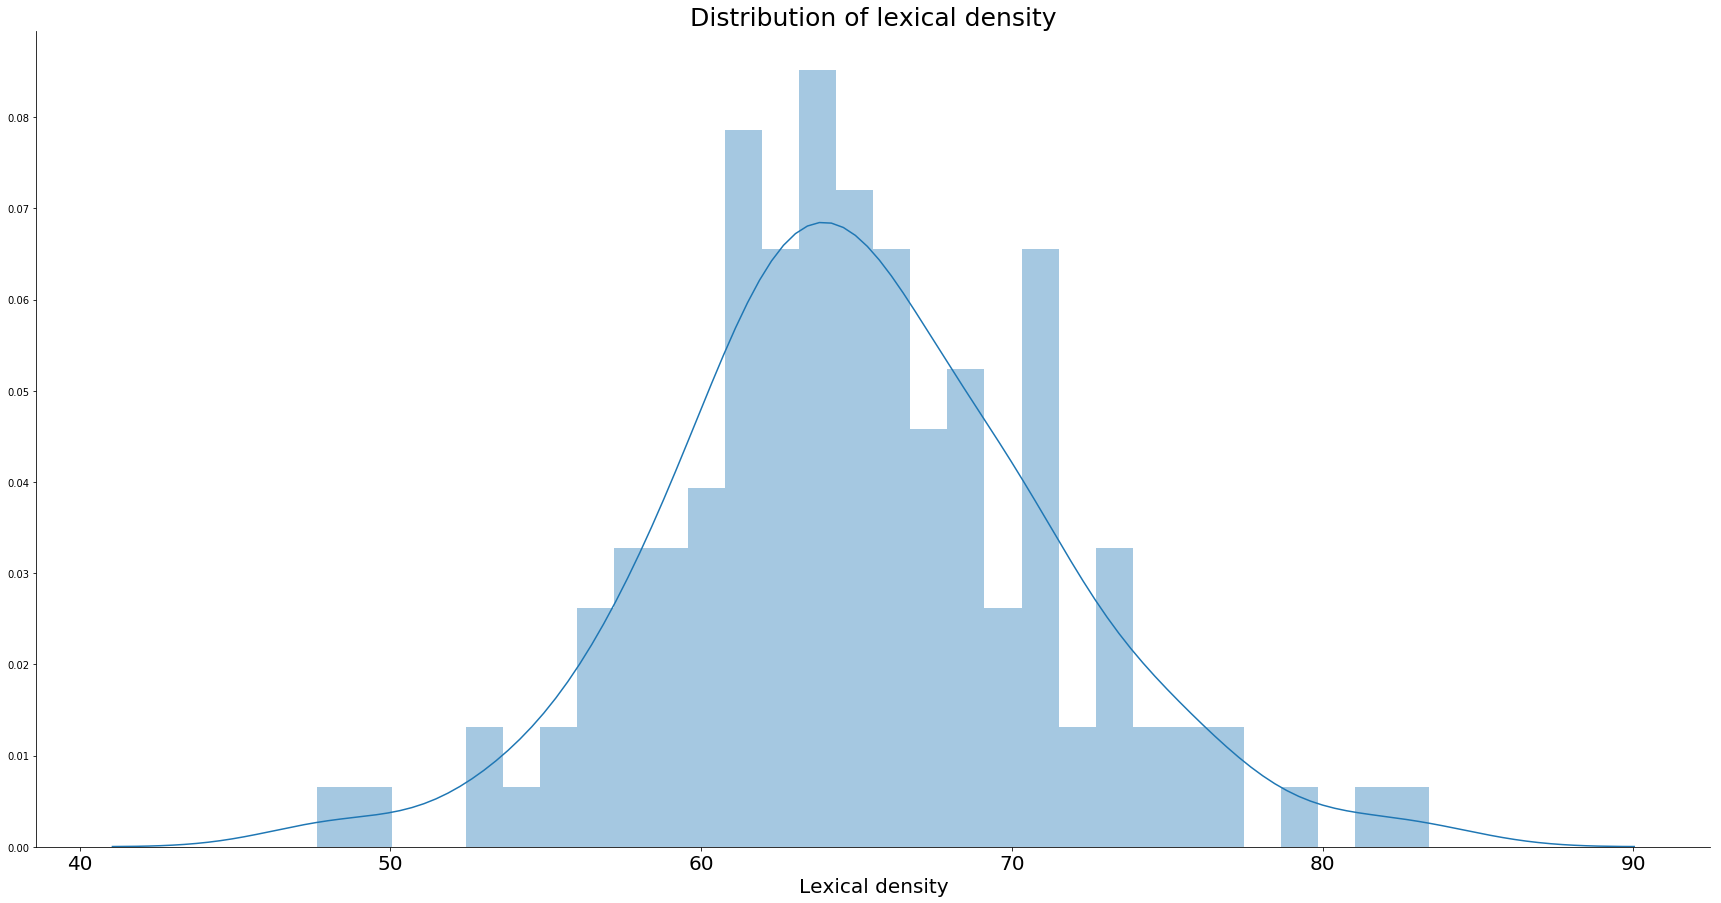

In [318]:
df['le_d'] = df['le_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['le_d'] > 0]['le_d'], bins=30)
plt.xlabel('Lexical density', fontsize=20)
plt.title('Distribution of lexical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
sns.despine()
plt.plot();


## Lyrical density
Now, [Myles](http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html) also invented another metric. Basically "Lyrical density" is the amount of words per unit of time. How fast information travels, how many units of language can you put in a second?

In [319]:
df.sort_values(by='ly_d', ascending=False).head(5)[['name', 'album', 'year', 'ly_d']]

,name,album,year,ly_d
index,,,,
50,Guitarra y vos,Eco,2004,1.697396
14,La luna de Rasquí,Bailar en la cueva,2014,1.660829
11,Bailar en la cueva,Bailar en la cueva,2014,1.480205
0,Movimiento,Salvavidas de hielo,2017,1.428861
49,Todo se transforma,Eco,2004,1.409190


Almost coinciding with most words per song, those 5 have the "fastest spilled lyrics"

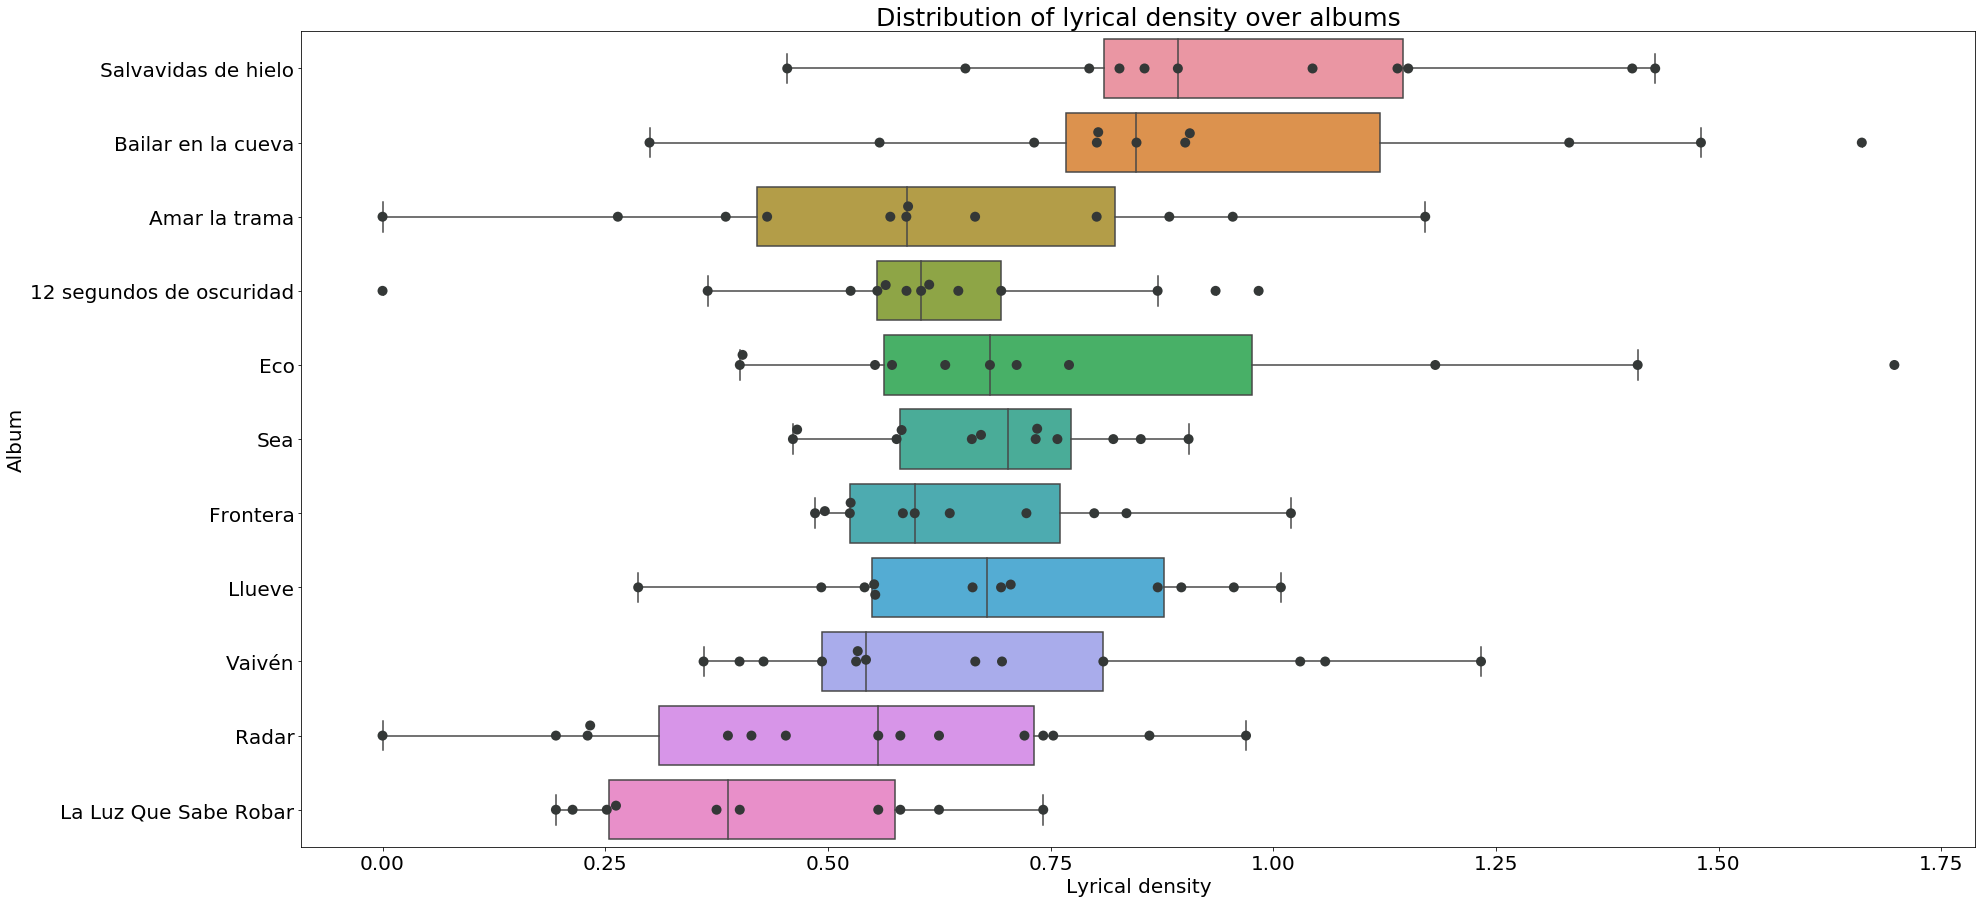

In [320]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="ly_d", y="album", data=df, orient='h')
ax = sns.swarmplot(x="ly_d", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Lyrical density', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of lyrical density over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

This is amazing. Let's bring back some past insights into the mix to analyse this one.
- The tendency in lyrical density goes up through time and albums.
- Remember that number of words showed the same trend? Well, they are linearly codependent.. so correlation must be over the roof. Though, the interesting thing is that lexical density has the inverted effect: __as with time Jorge wrote less dense-with-content lyrics, he sang faster__. May this be the case?

Let's check distribution also along the whole corpus of songs.

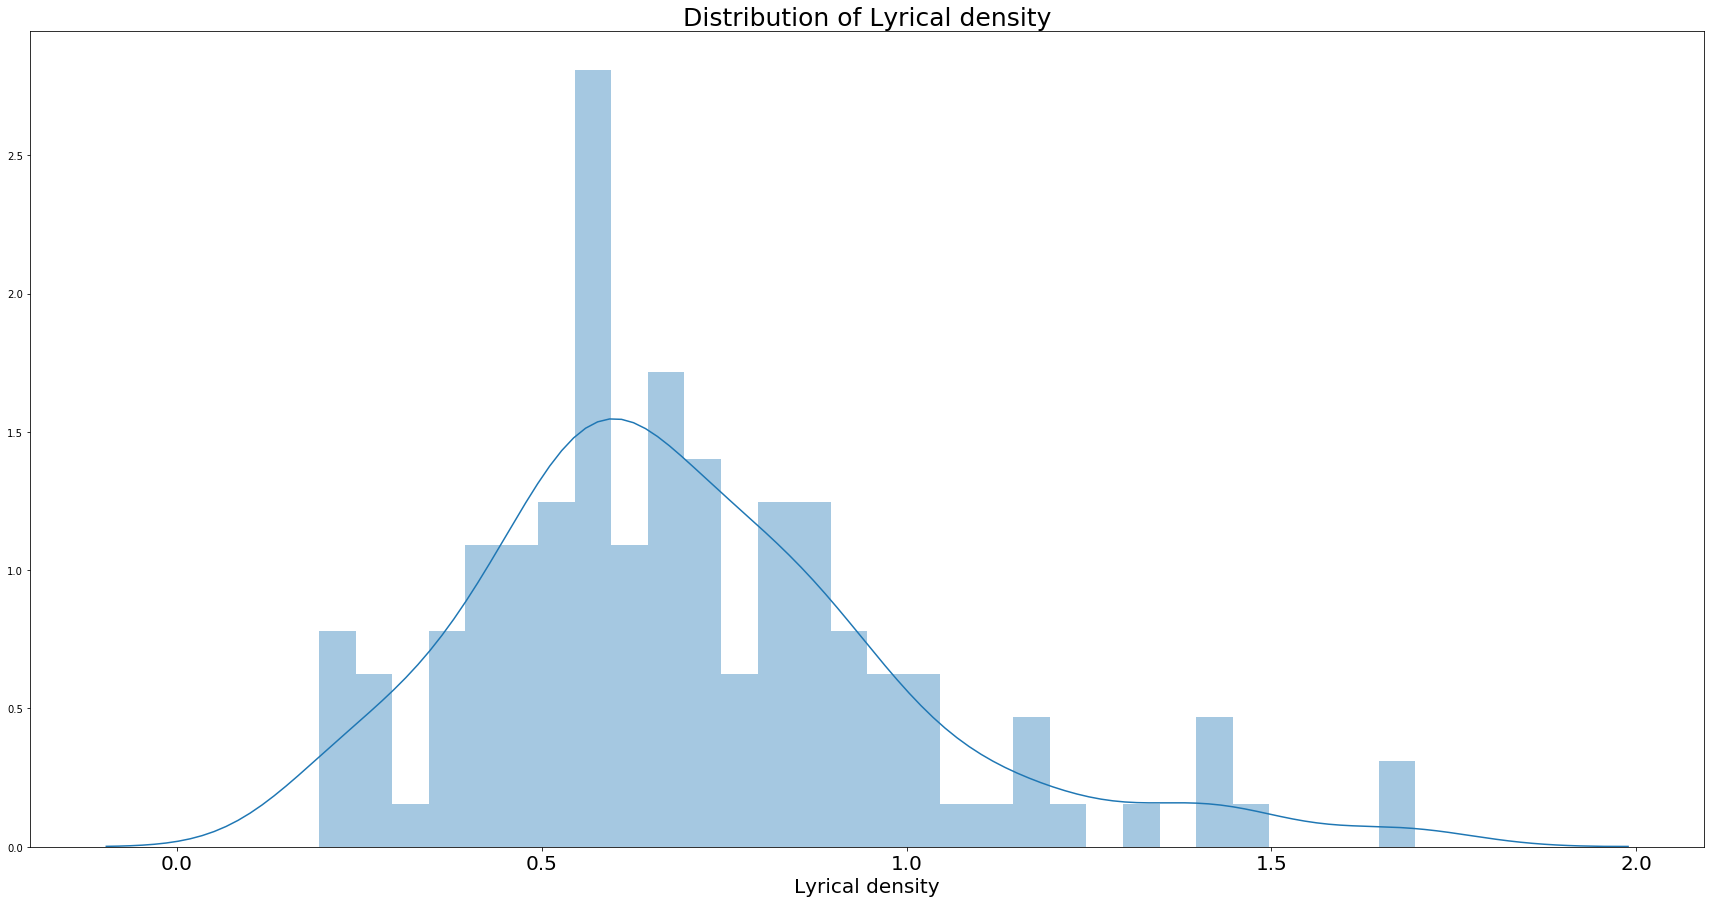

In [321]:
df['ly_d'] = df['ly_d'].fillna(0)

fig, ax = plt.subplots(figsize=(30,15))
ax = sns.distplot(df[df['ly_d'] > 0]['ly_d'], bins=30)
plt.xlabel('Lyrical density', fontsize=20)
plt.title('Distribution of Lyrical density', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();


Let's see if we can get some insight with confronting both densities in the same visualization

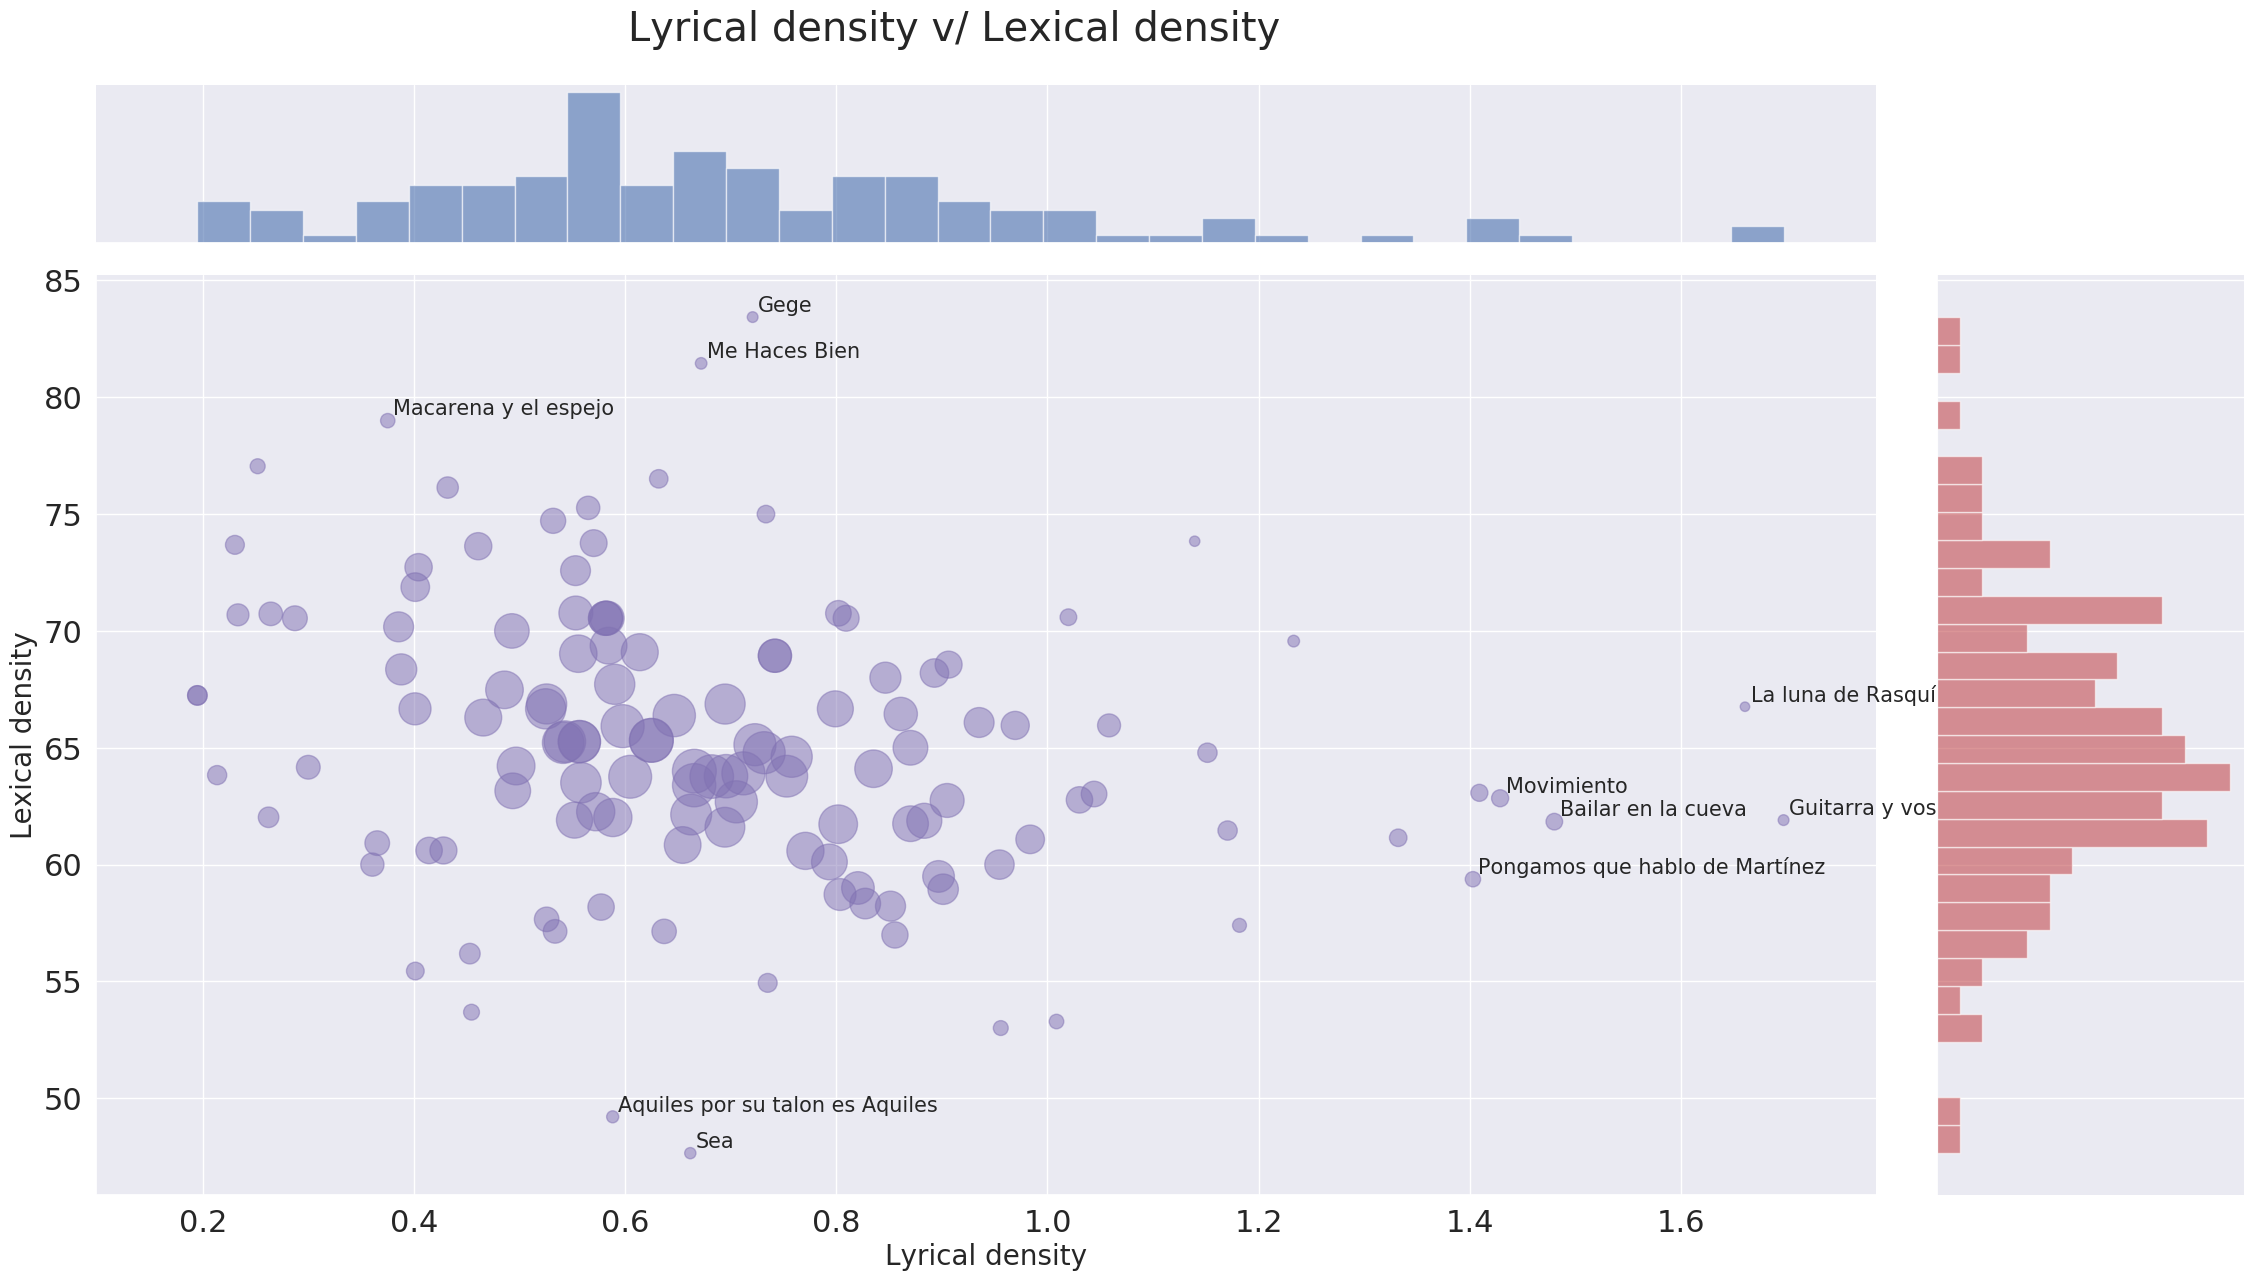

In [543]:
sns.set(font_scale = 2) #Horrendous hack to increase the size on jointgrid. Seaborn, step up.
df_to_plot = df[(df['ly_d'] > 0) & (df['le_d'] > 0)].reset_index(drop=True)
g = sns.JointGrid(x="ly_d", y="le_d", data=df_to_plot)

x = df_to_plot['ly_d']
y = df_to_plot['le_d']
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy) * 10000 # The 10K is for scale

g = g.plot_joint(plt.scatter, s=z, c='m', alpha=0.5)
_ = g.ax_marg_x.hist(df_to_plot['ly_d'], color="b", alpha=.6, bins=30)
_ = g.ax_marg_y.hist(df_to_plot['le_d'], color="r", alpha=.6, orientation="horizontal", bins=30)
plt.xlabel('Lyrical density', fontsize=20)
plt.ylabel('Lexical density', fontsize=20)
g.fig.suptitle('Lyrical density v/ Lexical density') # can also get the figure from plt.gcf()
g.fig.set_figwidth(30)
g.fig.set_figheight(15)

# Calculate outliers
z_score = np.abs(stats.zscore(df_to_plot[['ly_d', 'le_d']]))
threshold = 2
out_x, _ = np.where(z_score > threshold) 

# Indices to annotate
out_x = np.delete(out_x, [4,6]) # Deleting two outliers just for visualization purposes
out = df_to_plot.loc[out_x]
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['name'], xy=(r["ly_d"], r["le_d"]), 
            xytext=(4,4), textcoords ="offset points", fontsize=15 )
for row in out.iterrows():
    ann(row)


plt.plot();
sns.reset_defaults()

By checking the outliers of this little graph, we can see that:
    - Like we said before, songs like "Movimiento", "La luna de Rasquí", "Guitarra y vos" y "Pongamos que hablo de Martínez" carry a big lyrical density while a relative mean lexical one. This means they spit lots of words out per second (more than on

# Sentiment analysis

In [39]:
lexicon = EmoLex('data/lexicon_spanish.txt')


Let's check the song "Transporte"

In [40]:
summary = lexicon.summarize_doc(df.loc[51].tokens)
summary

{'anger': 0.01818181818181818,
 'anticipation': 0.05454545454545454,
 'disgust': 0.0,
 'fear': 0.0,
 'joy': 0.07272727272727272,
 'negative': 0.0,
 'positive': 0.09090909090909091,
 'sadness': 0.0,
 'surprise': 0.05454545454545454,
 'trust': 0.03636363636363636}

In [41]:
df['anger'] = 0.0
df['anticipation'] = 0.0
df['disgust'] = 0.0
df['fear'] = 0.0
df['joy'] = 0.0
df['negative'] = 0.0
df['positive'] = 0.0
df['sadness'] = 0.0
df['surprise'] = 0.0
df['trust'] = 0.0

In [42]:
for index, _ in df.iterrows():
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        summary = lexicon.summarize_doc(to_lower)
        for key in summary.keys():
            df.at[index, key] = summary[key]
    except:
        continue

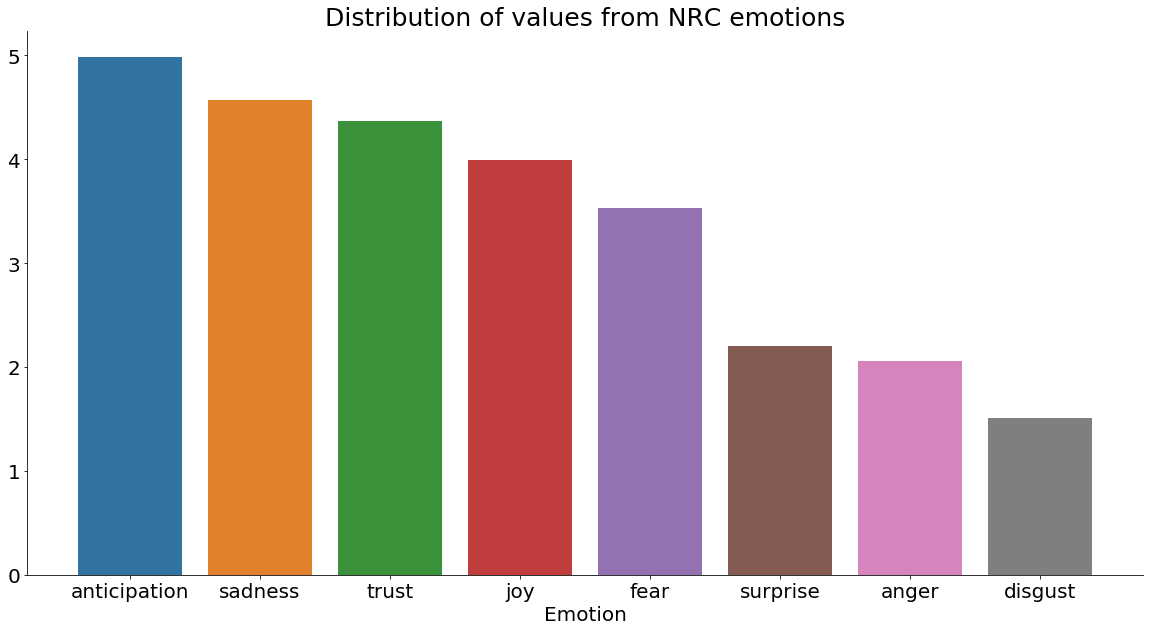

In [43]:
total_sentiments = pd.DataFrame(df.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
total_sentiments.columns = ['value']

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments)
plt.ylabel("")
plt.xlabel('Emotion', fontsize=20)
plt.title('Distribution of values from NRC emotions', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();


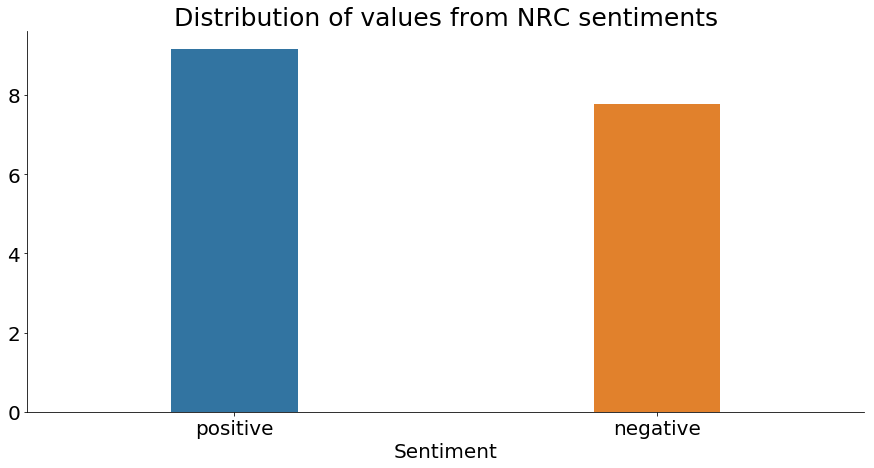

In [44]:
total_sentiment = pd.DataFrame(df.sum()[['positive', 'negative']])
total_sentiment.columns = ['value']

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x=total_sentiment.index, y='value', data=total_sentiment)
plt.ylabel("")
plt.xlabel('Sentiment', fontsize=20)
plt.title('Distribution of values from NRC sentiments', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - .3

    # we change the bar width
    patch.set_width(.3)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)
sns.despine()
plt.plot();


In [45]:
columns = ['word','fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust', 'positive', 'negative']

In [46]:
word_appearances_by_sentiment = pd.DataFrame(columns=columns)
for index, _ in df.iterrows():
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        annotation = lexicon.annotate_doc(to_lower)
        for token, a_set in zip(to_lower, annotation):
            row = [token] + [x in a_set for x in columns[1:]]
            appending_df = pd.DataFrame([row], columns=columns)
            word_appearances_by_sentiment = word_appearances_by_sentiment.append(appending_df)
    except:
        continue
word_appearances_by_sentiment = word_appearances_by_sentiment.groupby("word").agg(
    {'anger': np.sum,
     'anticipation': np.sum,
     'disgust': np.sum,
     'fear': np.sum,
     'joy': np.sum,
     'negative': np.sum,
     'positive': np.sum,
     'sadness': np.sum,
     'surprise': np.sum,
     'trust': np.sum}
)

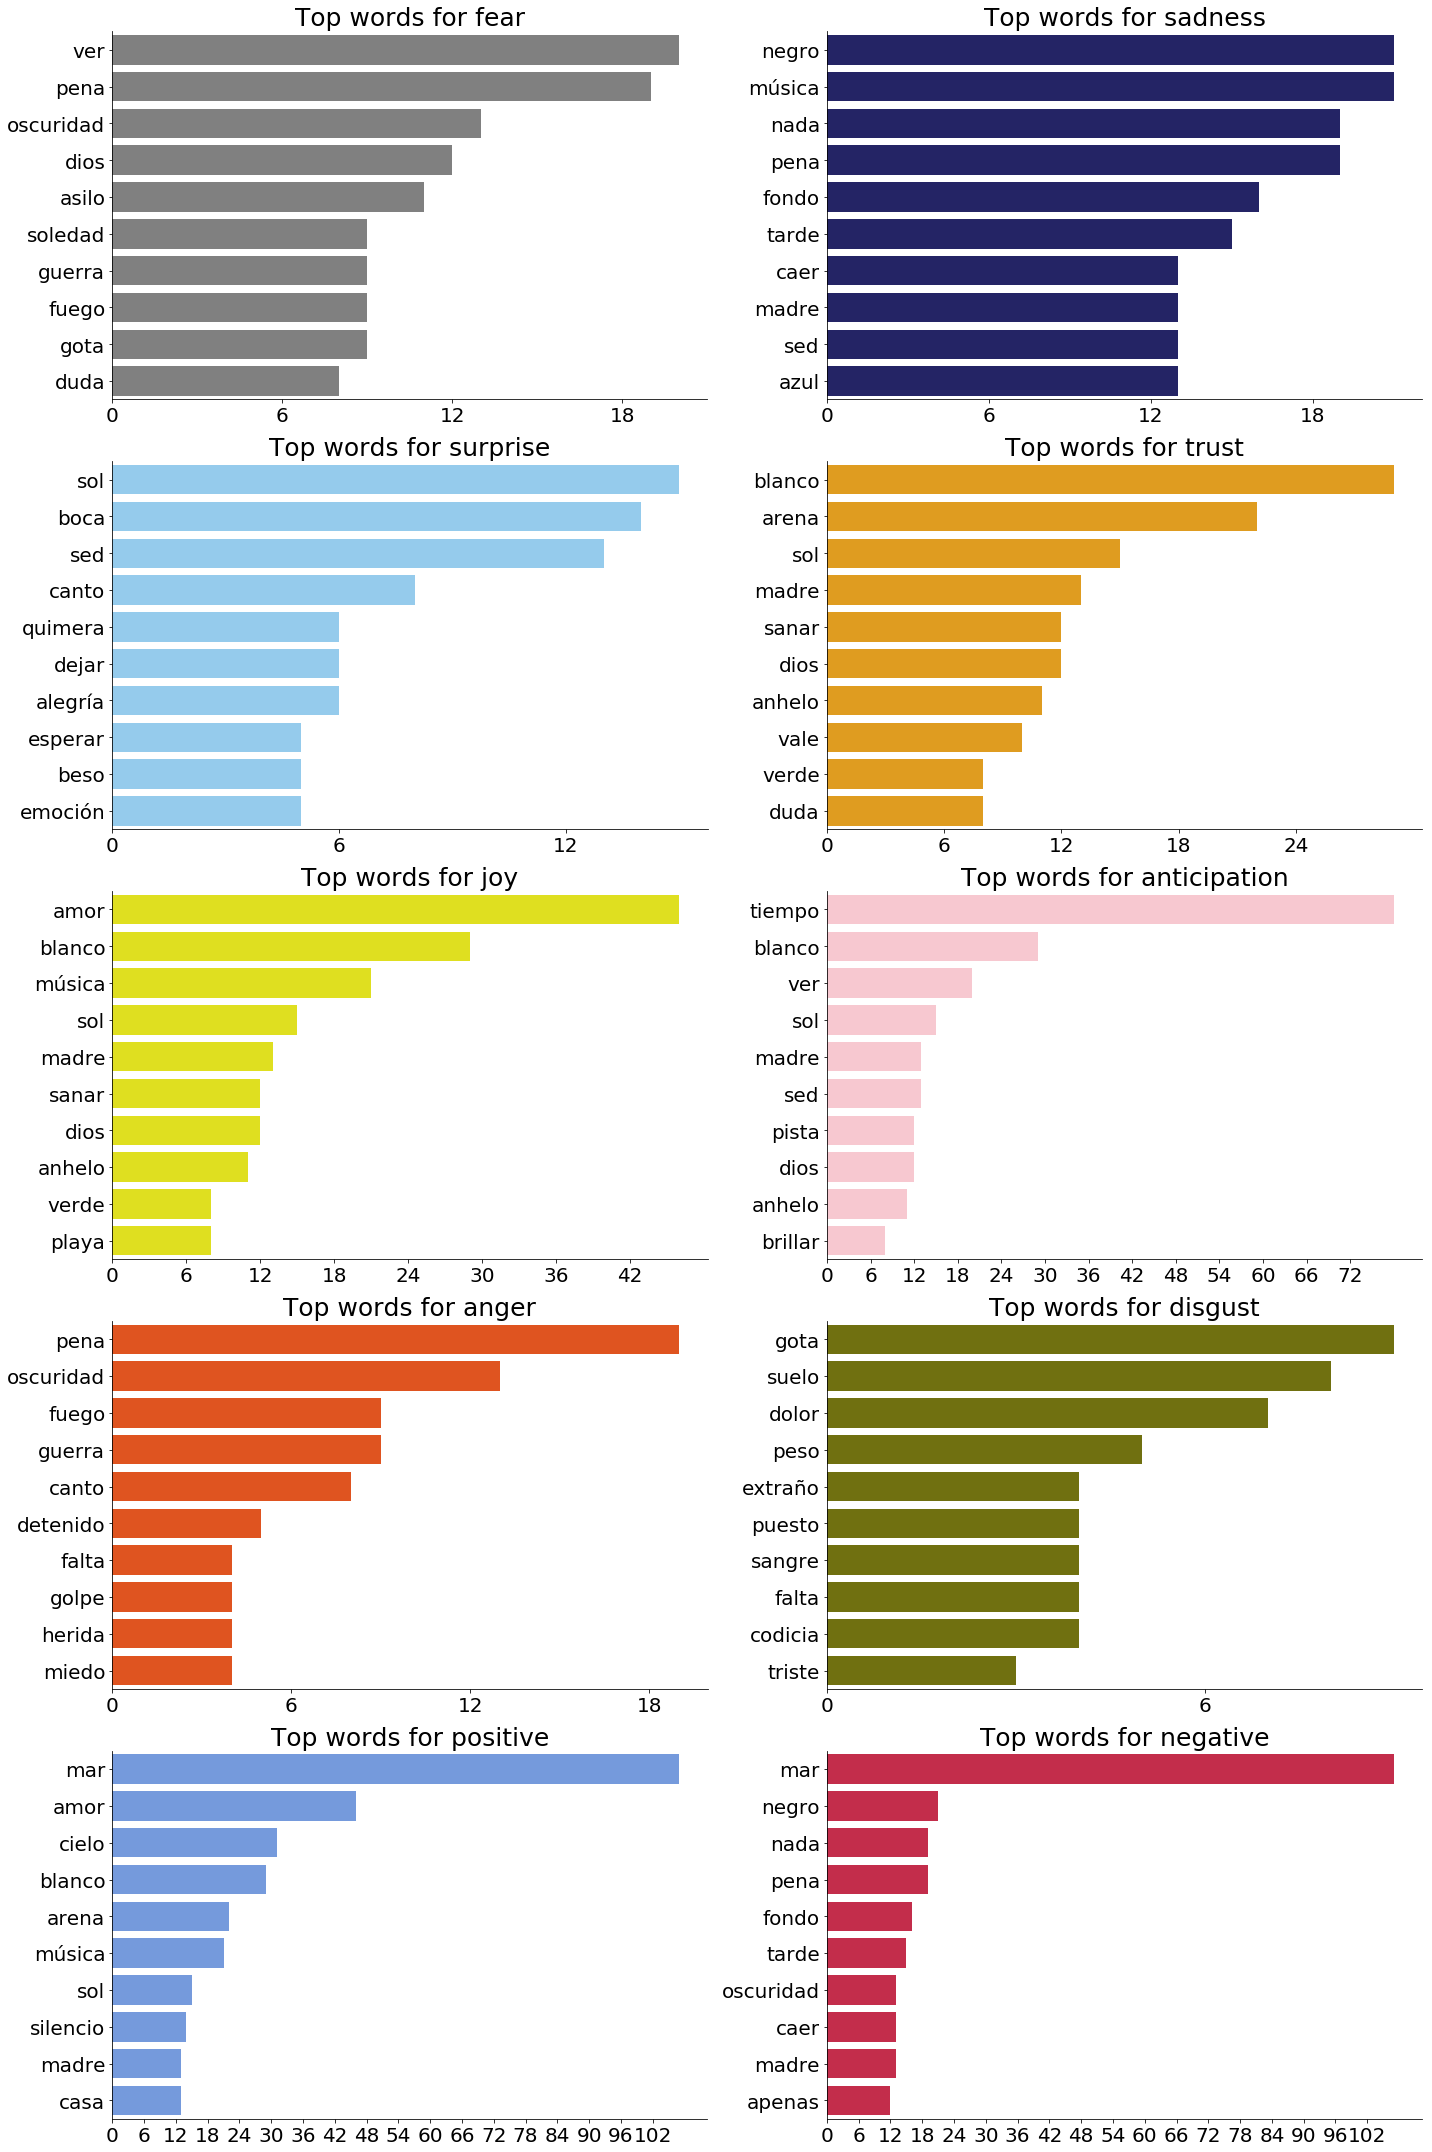

In [47]:
ROWS = 5
COLS = 2
cols_to_iterate = columns[1:]
colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        a_column = cols_to_iterate.pop(0)
        a_color = colors.pop(0)
        a_df = pd.DataFrame(word_appearances_by_sentiment.sort_values(by=[a_column], ascending=False)[a_column][:10])
        a_df.columns = ['count']
        sns.barplot(a_df['count'], a_df.index,orient='h', color=a_color, ax=axes[row, col])
        axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
        axes[row, col].set_xticks(range(0,max(a_df['count']), 6))
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.tight_layout()
plt.show()

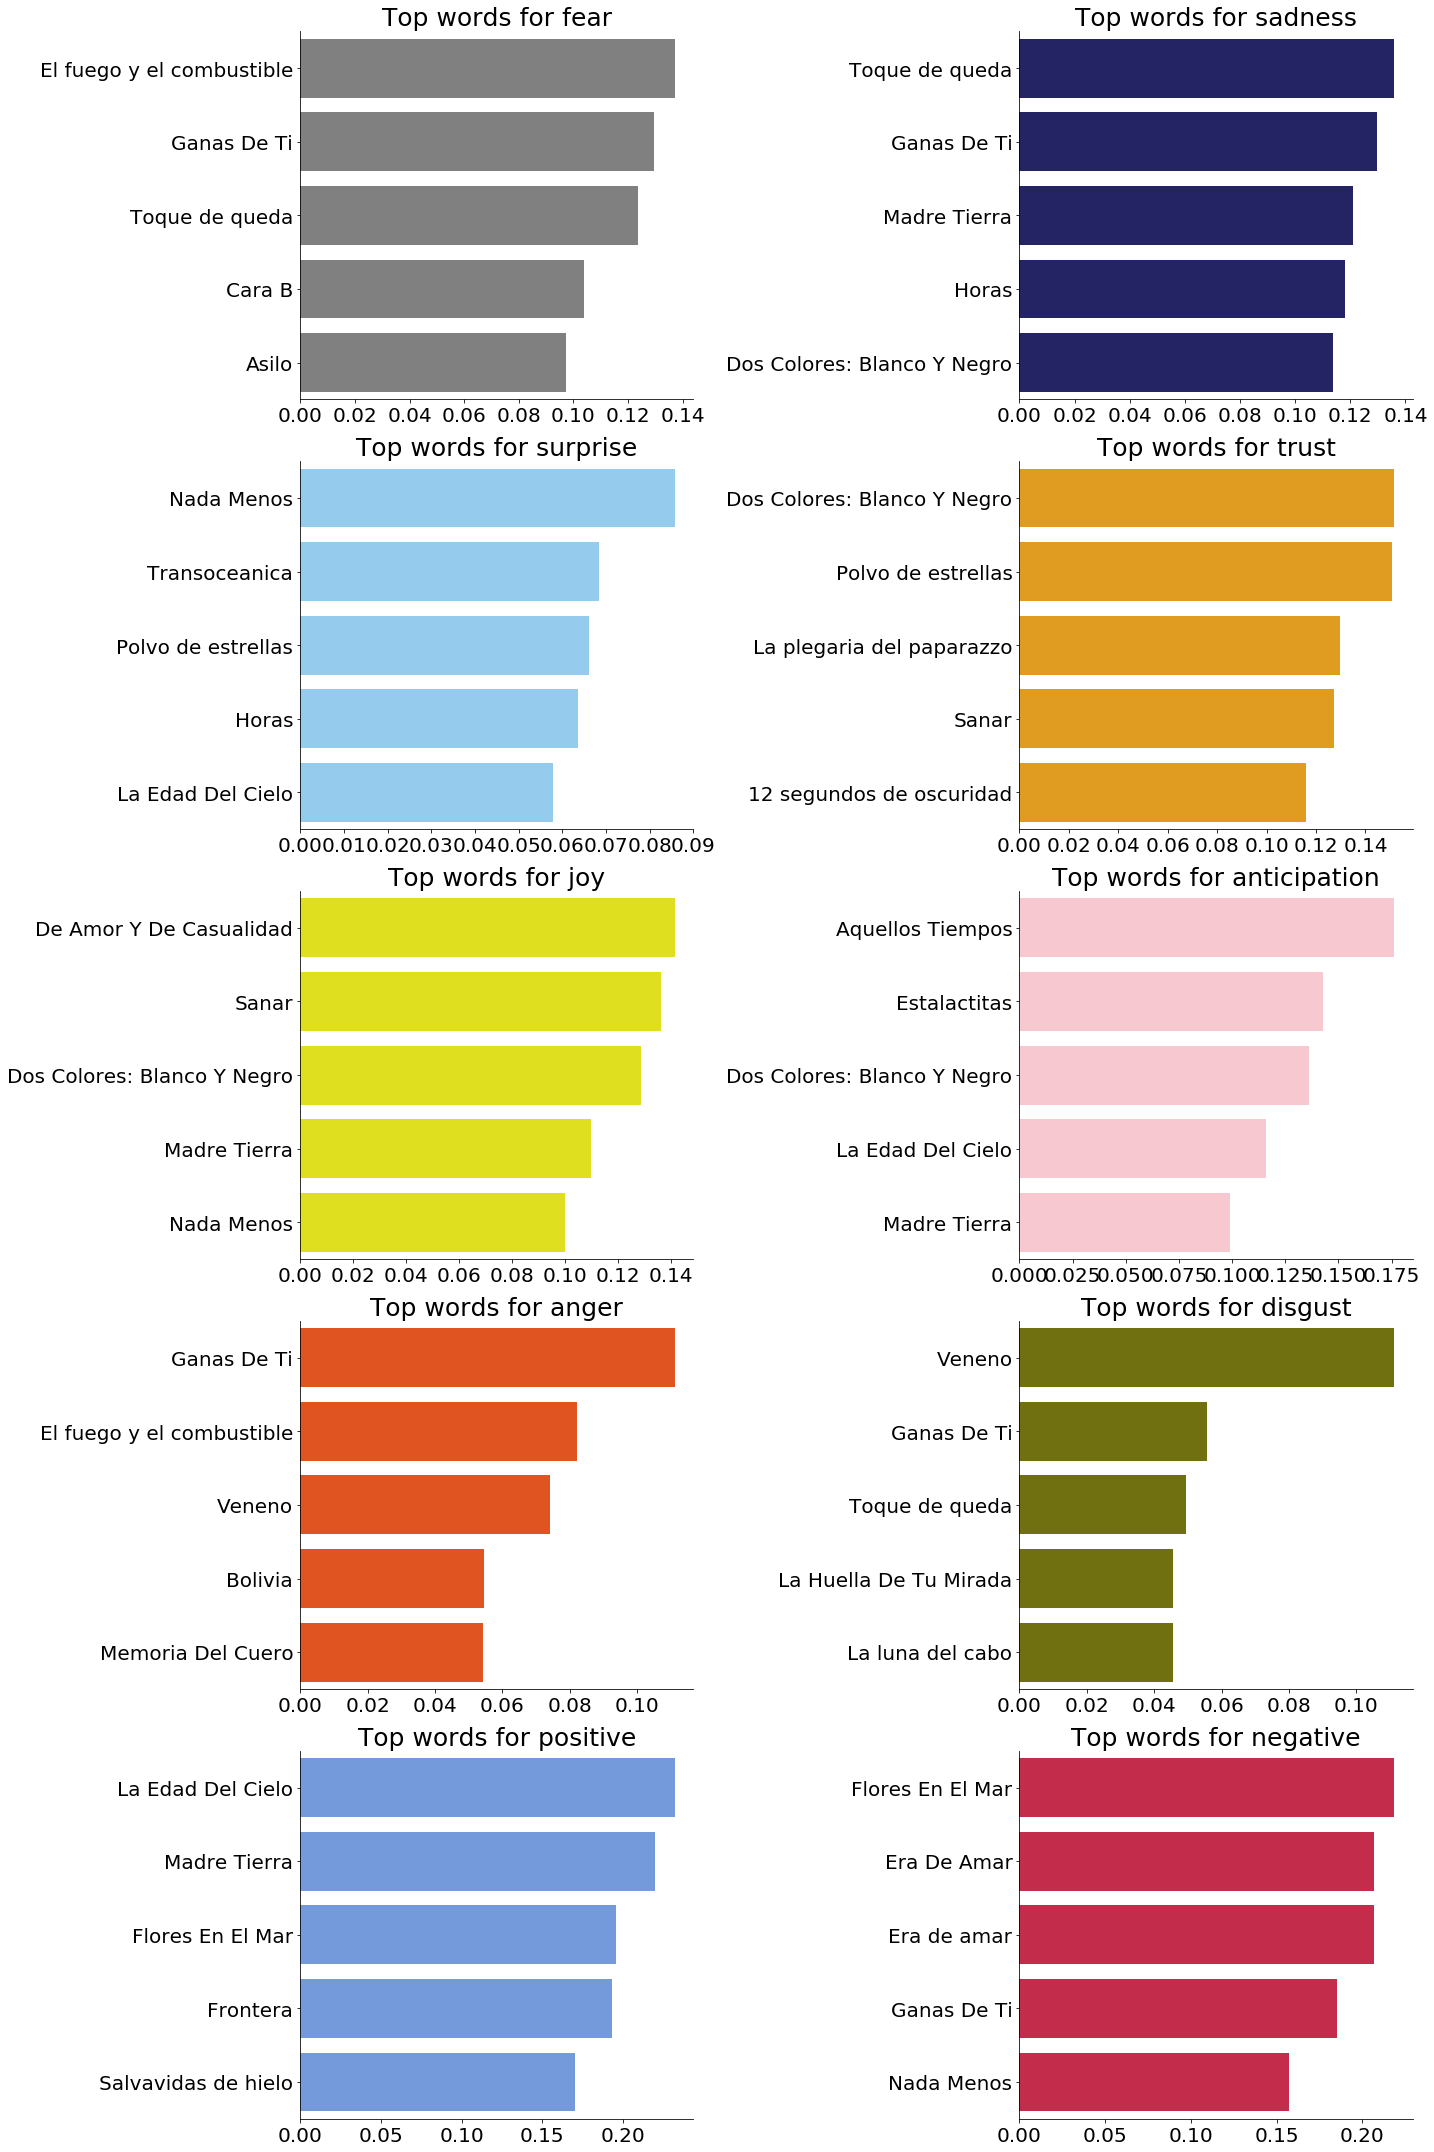

In [48]:
ROWS = 5
COLS = 2
cols_to_iterate = columns[1:]
colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        a_column = cols_to_iterate.pop(0)
        a_color = colors.pop(0)
        a_df = pd.DataFrame(df.sort_values(by=[a_column], ascending=False)[['name',a_column]][:5])
        sns.barplot(a_df[a_column], a_df.name, orient='h', color=a_color, ax=axes[row, col])
        axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
        #axes[row, col].set_xticks(range(0,max(a_df[a_column]), 6))
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
fig.tight_layout()
plt.show()

In [185]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]
years_for_albums = [
    1992, 1994, 1996, 1997, 1999, 
    2001, 2004, 2006, 2010, 2014, 
    2017
]

colormap = {
    'fear': 'grey', 
    'sadness': 'midnightblue', 
    'surprise': 'lightskyblue', 
    'trust': 'orange', 
    'joy': 'yellow', 
    'anticipation': 'pink', 
    'anger': 'orangered', 
    'disgust': 'olive', 
    'positive': 'cornflowerblue', 
    'negative': 'crimson'
}


emotions=['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']
sentiments=['positive', 'negative']
albums_by_emotion = pd.DataFrame(columns=['album', 'year'] + emotions + sentiments)

for an_album, a_year in zip(albums_ordered_by_year, years_for_albums):
    some_albums_emotions = pd.DataFrame(df[df['album'] == an_album].sum()[emotions])
    some_albums_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[sentiments])
    row = [an_album, a_year] + list(some_albums_emotions[0].values) + list(some_albums_sentiments[0].values)
    appending_df = pd.DataFrame([row], columns=['album', 'year'] + emotions + sentiments)
    albums_by_emotion = albums_by_emotion.append(appending_df)
albums_by_emotion = albums_by_emotion.reset_index(drop=True)
albums_by_emotion

,album,year,fear,sadness,surprise,trust,joy,anticipation,anger,disgust,positive,negative
0,La Luz Que Sabe Robar,1992,0.203686,0.385296,0.155135,0.284536,0.358232,0.357719,0.178083,0.156379,0.603337,0.436929
1,Radar,1994,0.276221,0.539762,0.248387,0.342851,0.393322,0.522680,0.209822,0.181305,1.055875,0.946799
2,Vaivén,1996,0.374724,0.719195,0.143359,0.381474,0.361346,0.534869,0.251901,0.135175,0.979585,1.029696
3,Llueve,1997,0.320040,0.340336,0.090775,0.304329,0.382169,0.357141,0.185393,0.143208,0.941885,0.860252
4,Frontera,1999,0.362460,0.403787,0.211708,0.432888,0.424484,0.705346,0.217928,0.125652,1.195333,0.697377
5,Sea,2001,0.276593,0.386082,0.303028,0.481634,0.435938,0.309596,0.132745,0.090931,0.876404,0.704091
6,Eco,2004,0.278267,0.300399,0.328133,0.528648,0.468932,0.442141,0.202439,0.142790,0.787769,0.548452
7,12 segundos de oscuridad,2006,0.441877,0.487261,0.138745,0.526699,0.306674,0.377294,0.252825,0.141355,0.654582,0.744588
8,Amar la trama,2010,0.377031,0.430701,0.179193,0.290156,0.213433,0.387376,0.130580,0.110726,0.528819,0.735744
9,Bailar en la cueva,2014,0.290060,0.309666,0.171506,0.455471,0.330000,0.410849,0.187282,0.197405,0.746761,0.624168


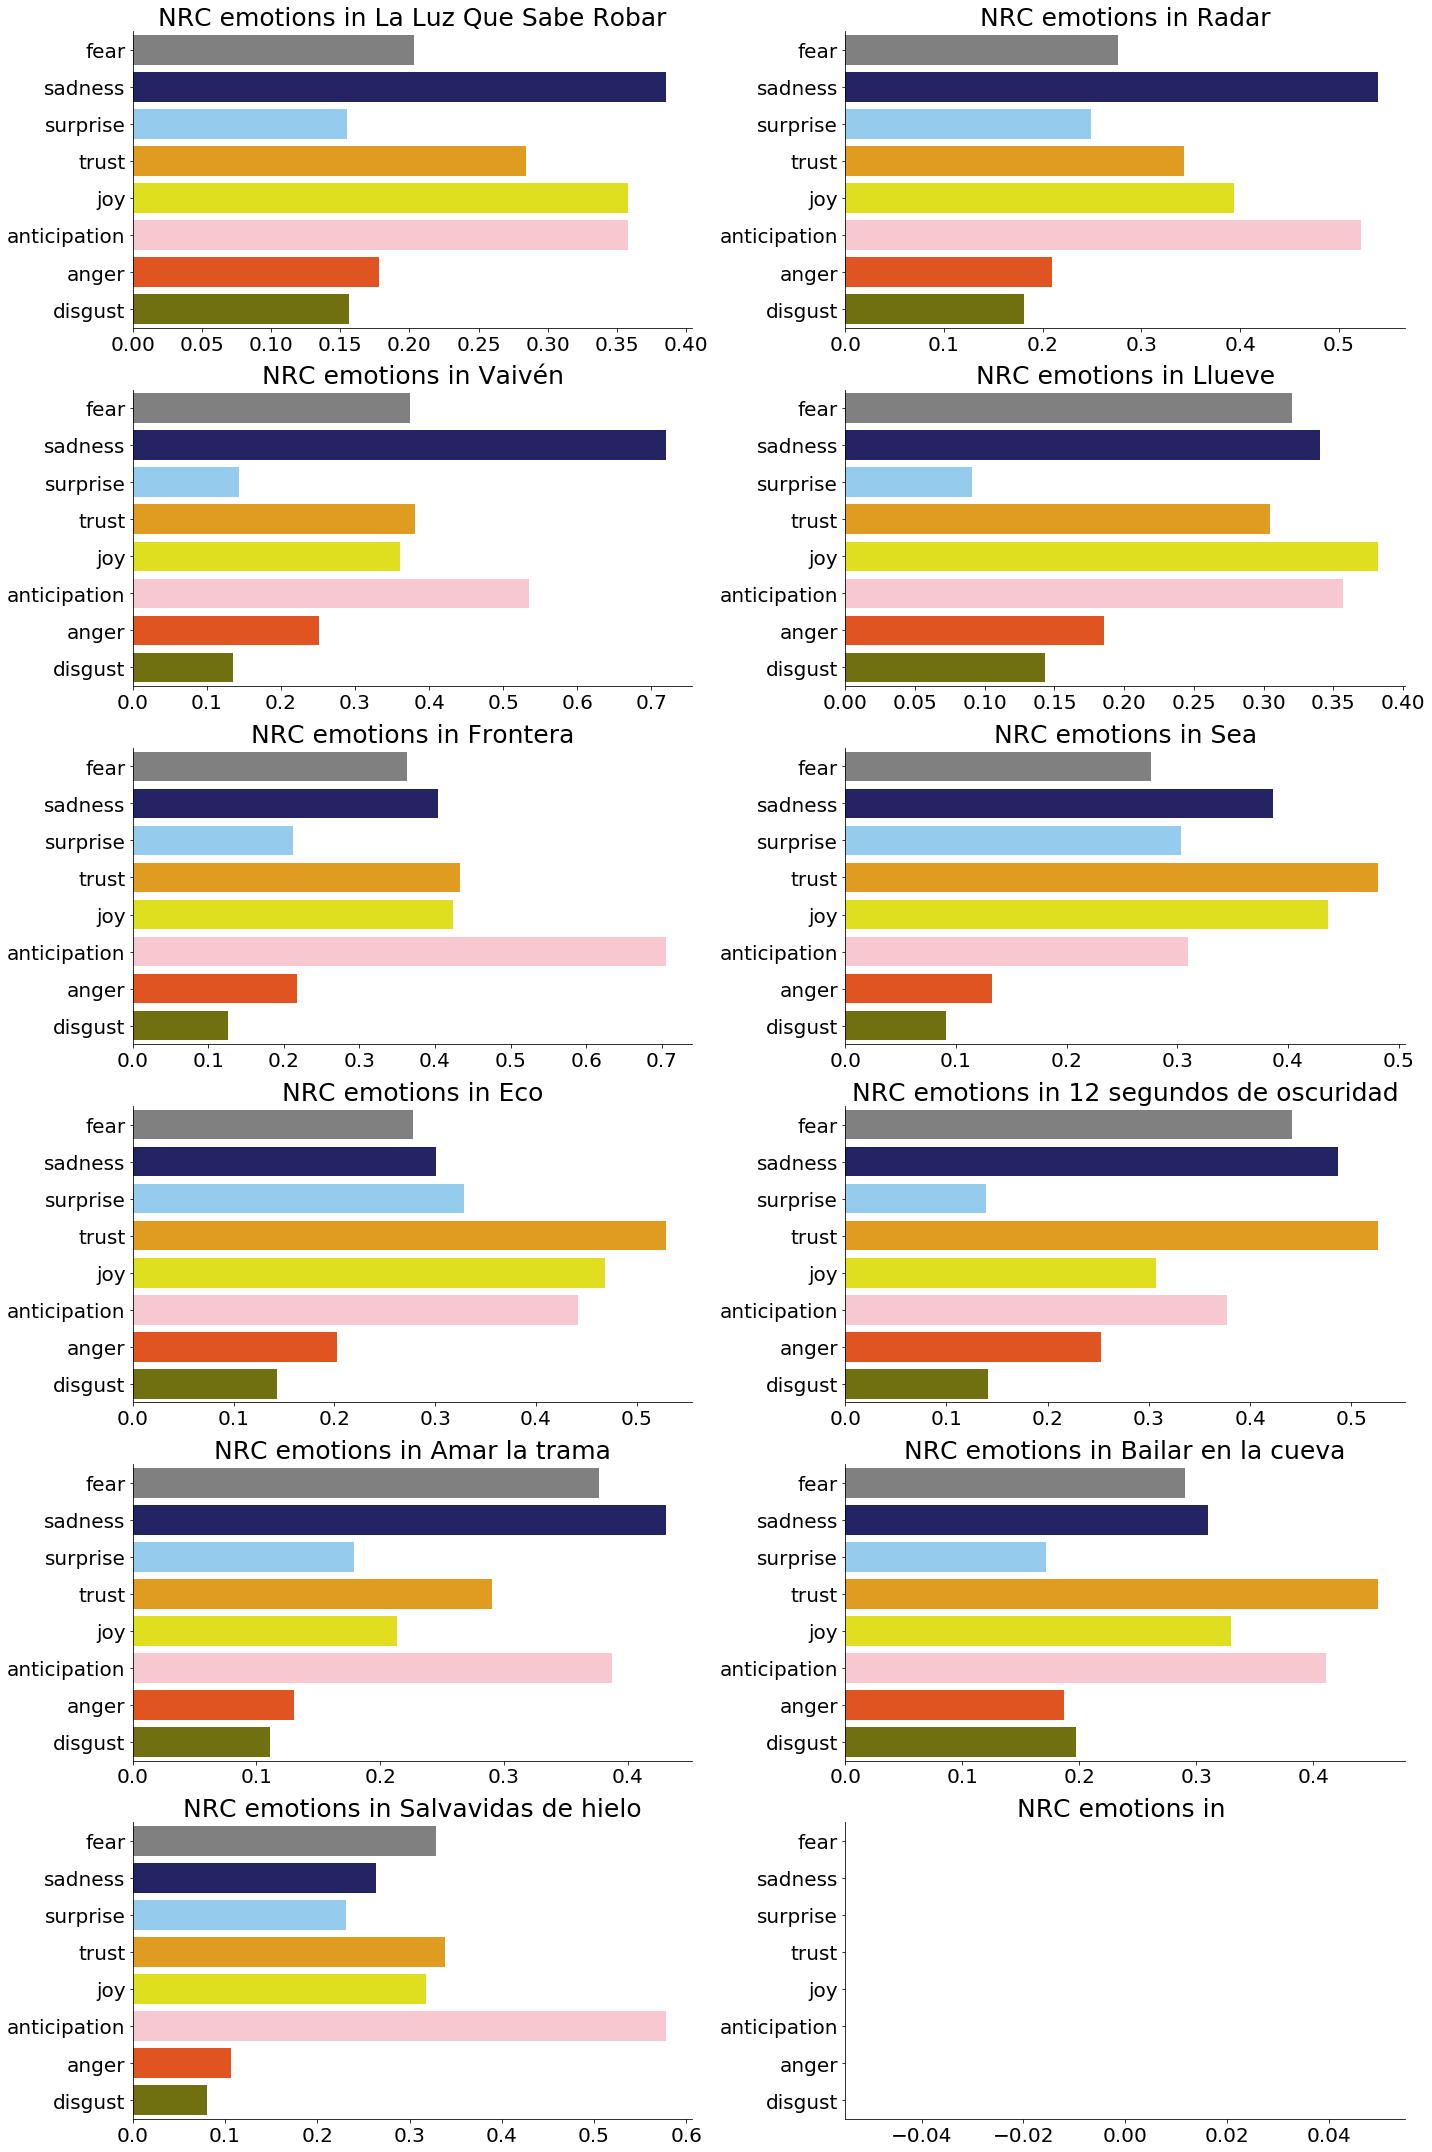

In [189]:
ROWS = 6
COLS = 2
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo', ""
]
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        an_album = cols_to_iterate.pop(0)
        
        total_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']])
        total_sentiments.columns = ['value']
        sns.barplot(
            y=total_sentiments.index, 
            x='value', 
            orient='h', 
            data=total_sentiments, 
            ax=axes[row, col], 
            #hue=total_sentiments.index,
            palette=colormap
        )

        axes[row, col].set_title('NRC emotions in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.tight_layout()
plt.show()


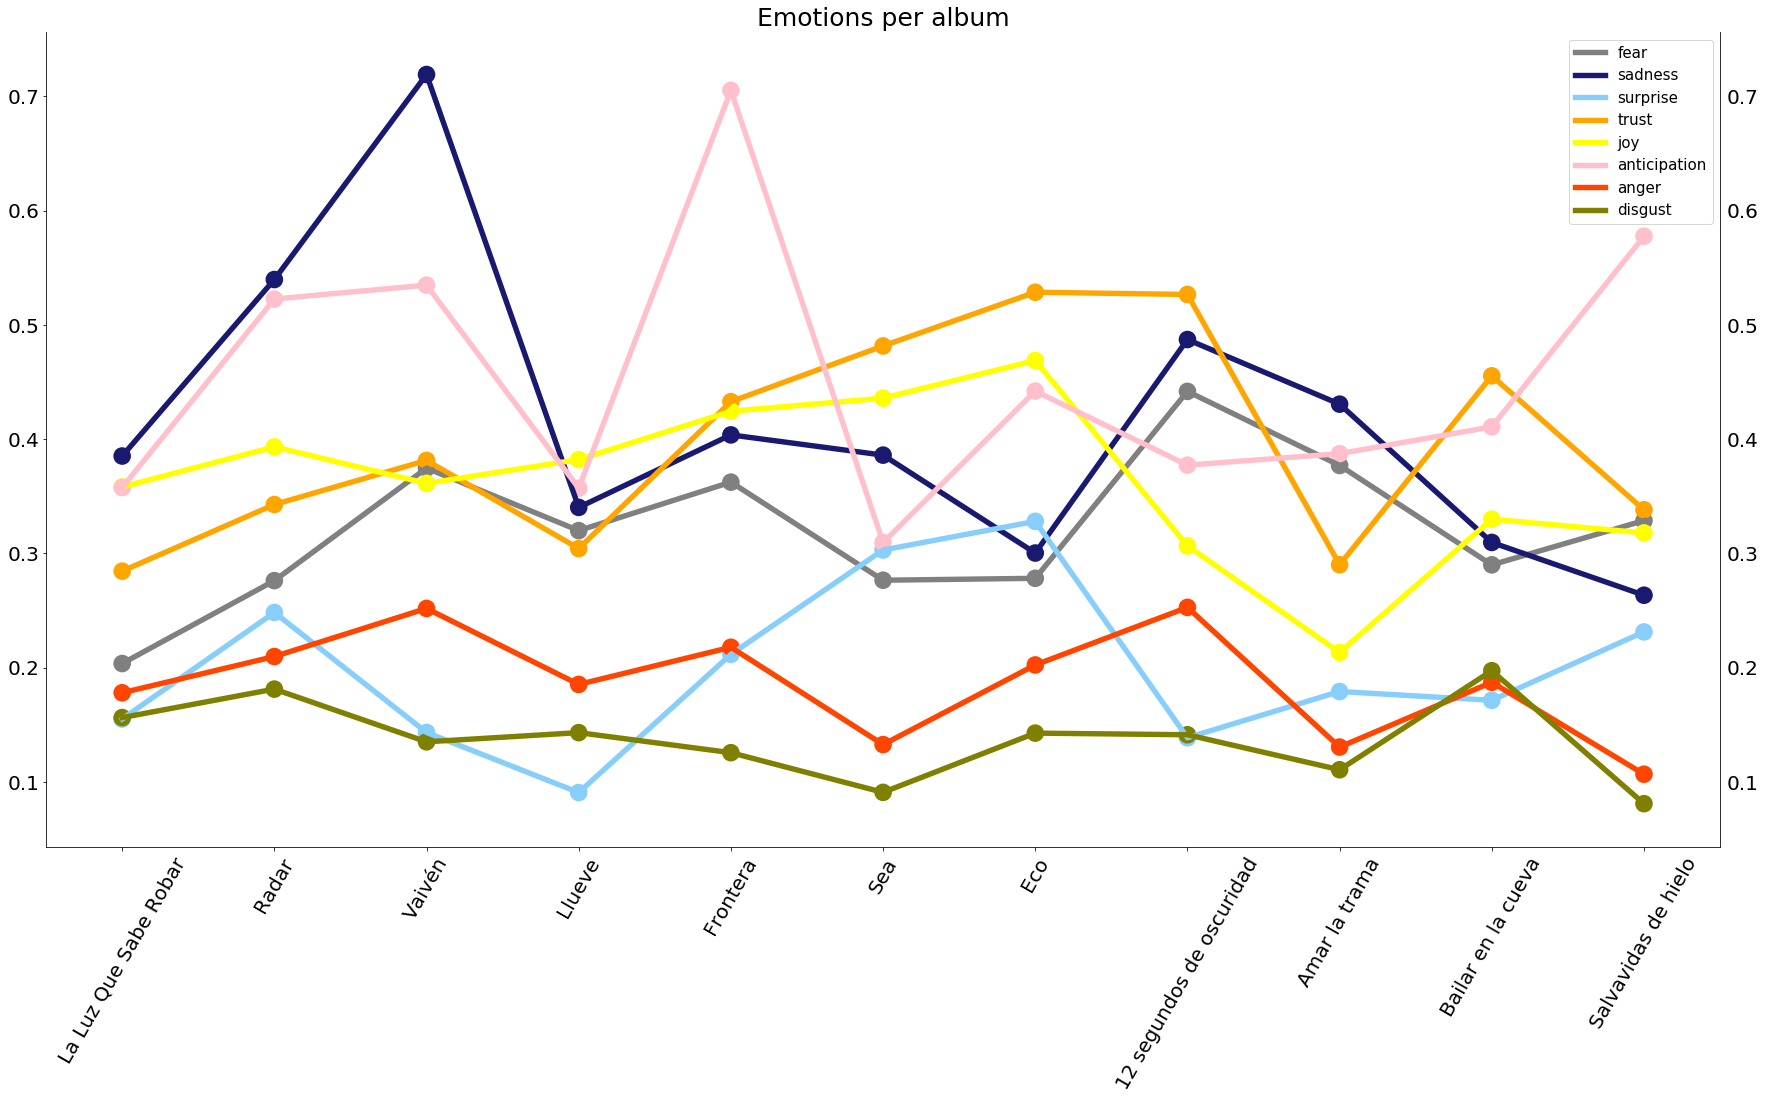

In [51]:
fig, ax = plt.subplots(figsize=(30,15))
for an_emotion in emotions:
    sns.pointplot(x="album", y=an_emotion, data=albums_by_emotion, color=colormap[an_emotion], scale=2,)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Emotions per album", fontdict={'fontsize': 25})
plt.ylabel("")
plt.xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax.legend(handles=ax.lines[::len(albums_by_emotion)+1], labels=emotions, prop={'size': 15})
plt.show();

KeyError: "None of [['positive', 'negative']] are in the [index]"

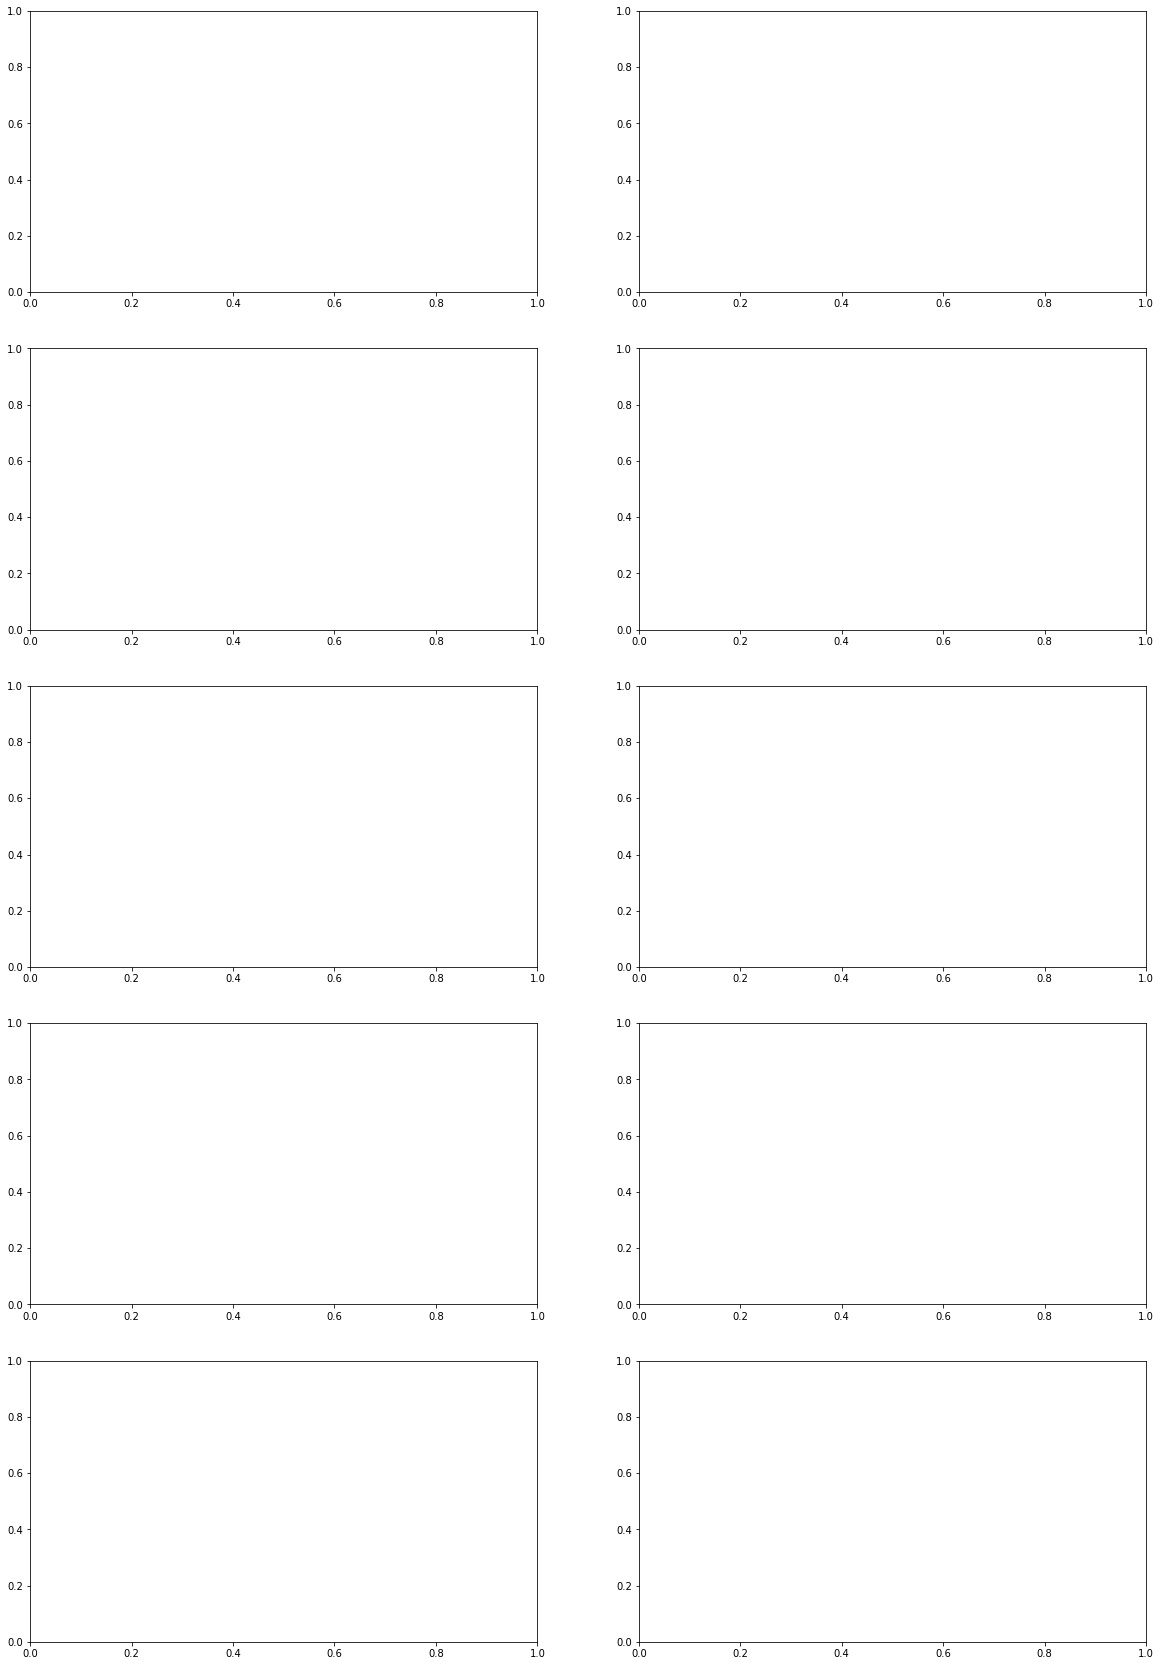

In [230]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo'
]

ROWS = 5
COLS = 2
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        an_album = cols_to_iterate.pop(0)
        
        total_sentiments = pd.DataFrame(df[df['album'] == an_album].sum()[['positive', 'negative']])
        total_sentiments.columns = ['value']
        sns.barplot(
            y=total_sentiments.index, 
            x='value', 
            orient='h', 
            data=total_sentiments, 
            ax=axes[row, col], 
            #hue=total_sentiments.index,
            palette=colormap
        )

        axes[row, col].set_title('NRC sentiments in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.show()


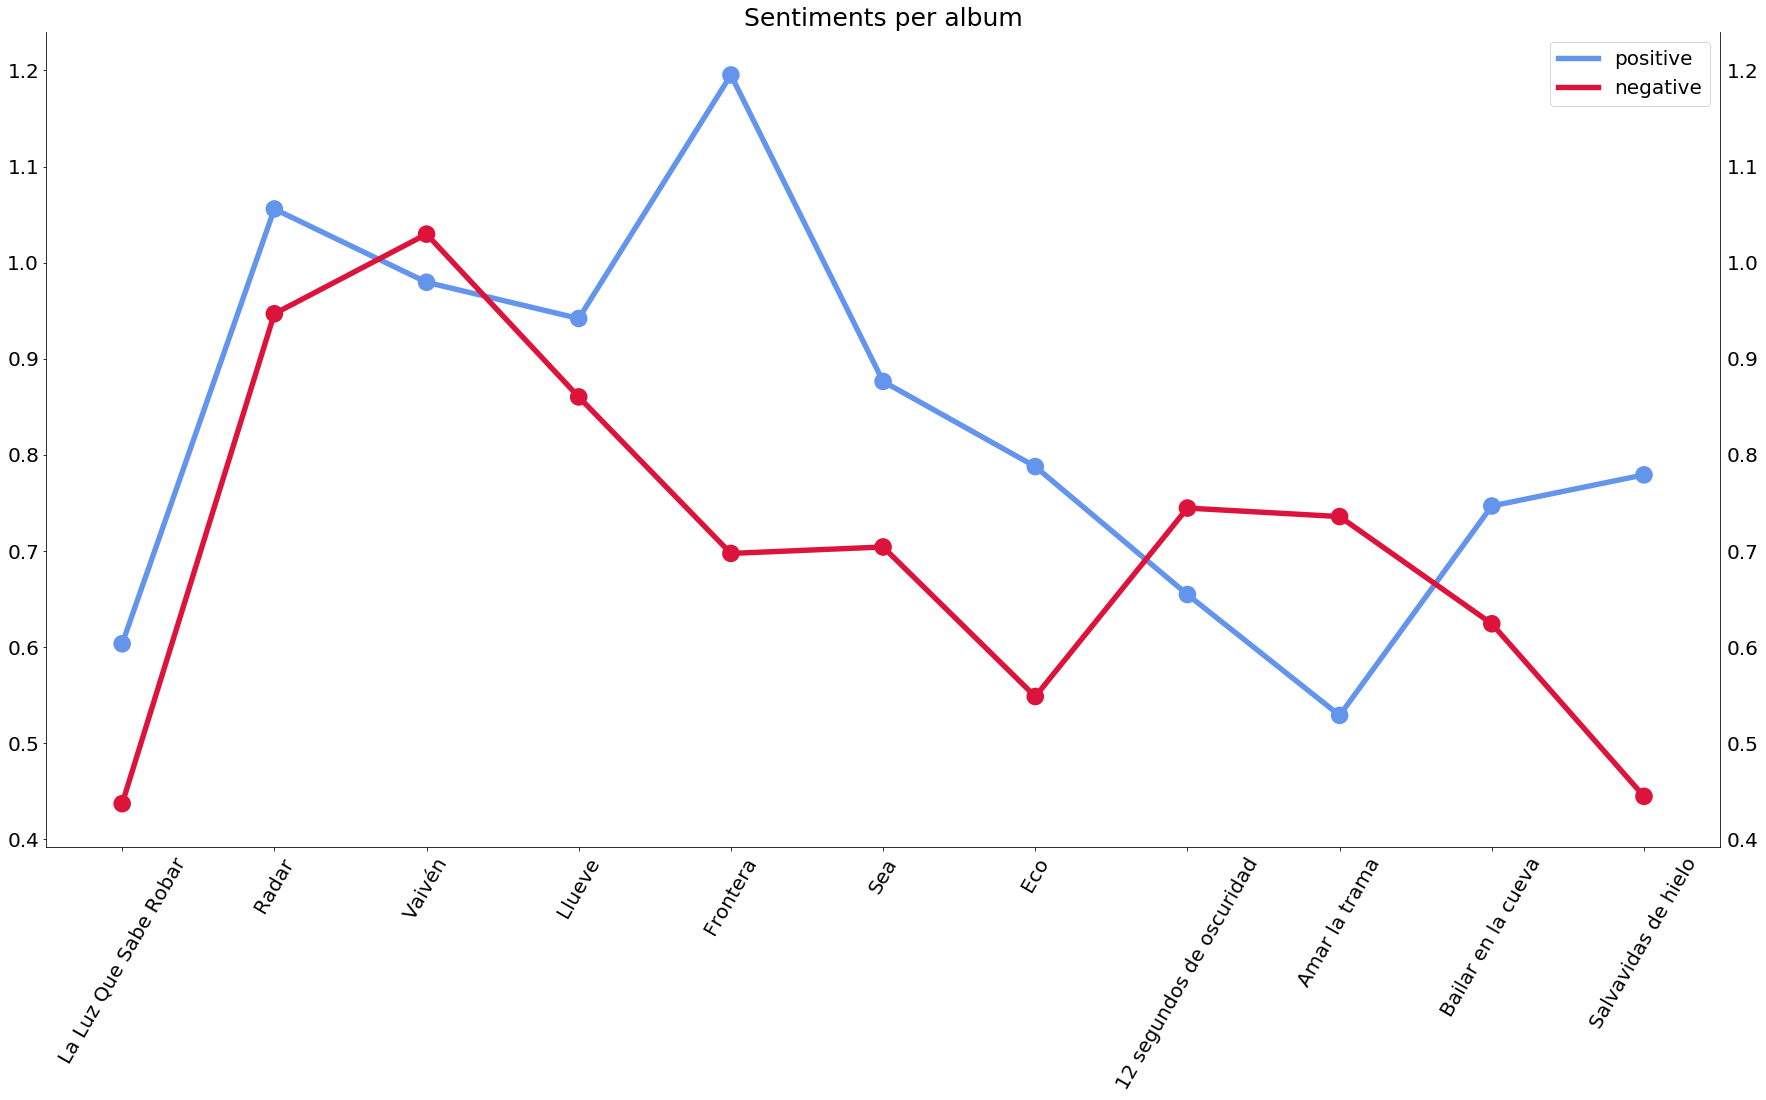

In [54]:
fig, ax = plt.subplots(figsize=(30,15))
for a_sentiment in sentiments:
    sns.pointplot(x="album", y=a_sentiment, data=albums_by_emotion, color=colormap[a_sentiment], scale=2,)
ax.spines["top"].set_visible(False)
plt.tick_params(axis='both', labelright=True, labelsize=20)
ax.set_title("Sentiments per album", fontdict={'fontsize': 25})
plt.ylabel("")
plt.xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax.legend(handles=ax.lines[::len(albums_by_emotion)+1], labels=sentiments, prop={'size': 20})
plt.show();

In [61]:
spoti_df = df[['name', 'album', 'acousticness', 'danceability', 'energy', 'key', 'tempo',
       'time_signature', 'valence', 'mode']]
spoti_df[df['time_signature']==5]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
5,Asilo,Salvavidas de hielo,0.808,0.502,0.239,0.0,127.484,5.0,0.367,1.0


In [65]:
spoti_df.loc[5, 'time_signature'] = 3.0

/Users/alex/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [67]:
spoti_df[df['time_signature']==1]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
77,Alto El Fuego,Frontera,0.898,0.655,0.162,2.0,82.264,1.0,0.649,1.0


In [68]:
spoti_df.loc[77, 'time_signature'] = 3.0

/Users/alex/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [76]:
spoti_df.head()

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
0,Movimiento,Salvavidas de hielo,0.900,0.784,0.457,2.0,125.021,4.0,0.546,1.0
1,Telefonía,Salvavidas de hielo,0.829,0.915,0.592,6.0,126.060,4.0,0.841,0.0
2,Silencio,Salvavidas de hielo,0.263,0.887,0.568,4.0,127.923,4.0,0.127,0.0
3,Pongamos que hablo de Martínez,Salvavidas de hielo,0.893,0.849,0.458,9.0,119.950,4.0,0.461,1.0
4,Estalactitas,Salvavidas de hielo,0.797,0.772,0.630,0.0,136.019,4.0,0.909,1.0


In [72]:
spoti_df.tempo.describe()

count    131.000000
mean     121.672885
std       27.364699
min       63.705000
25%      101.973000
50%      124.974000
75%      139.971500
max      192.012000
Name: tempo, dtype: float64

Mean for tempo is 122. Max is 192 and min is 64.

In [73]:
spoti_df[spoti_df['tempo'] == 192.012000]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
18,La plegaria del paparazzo,Bailar en la cueva,0.0492,0.665,0.731,6.0,192.012,4.0,0.732,1.0


In [74]:
spoti_df[spoti_df['tempo'] == 63.705000]

,name,album,acousticness,danceability,energy,key,tempo,time_signature,valence,mode
index,,,,,,,,,,
41,Hermana duda,12 segundos de oscuridad,0.126,0.305,0.627,7.0,63.705,4.0,0.411,1.0


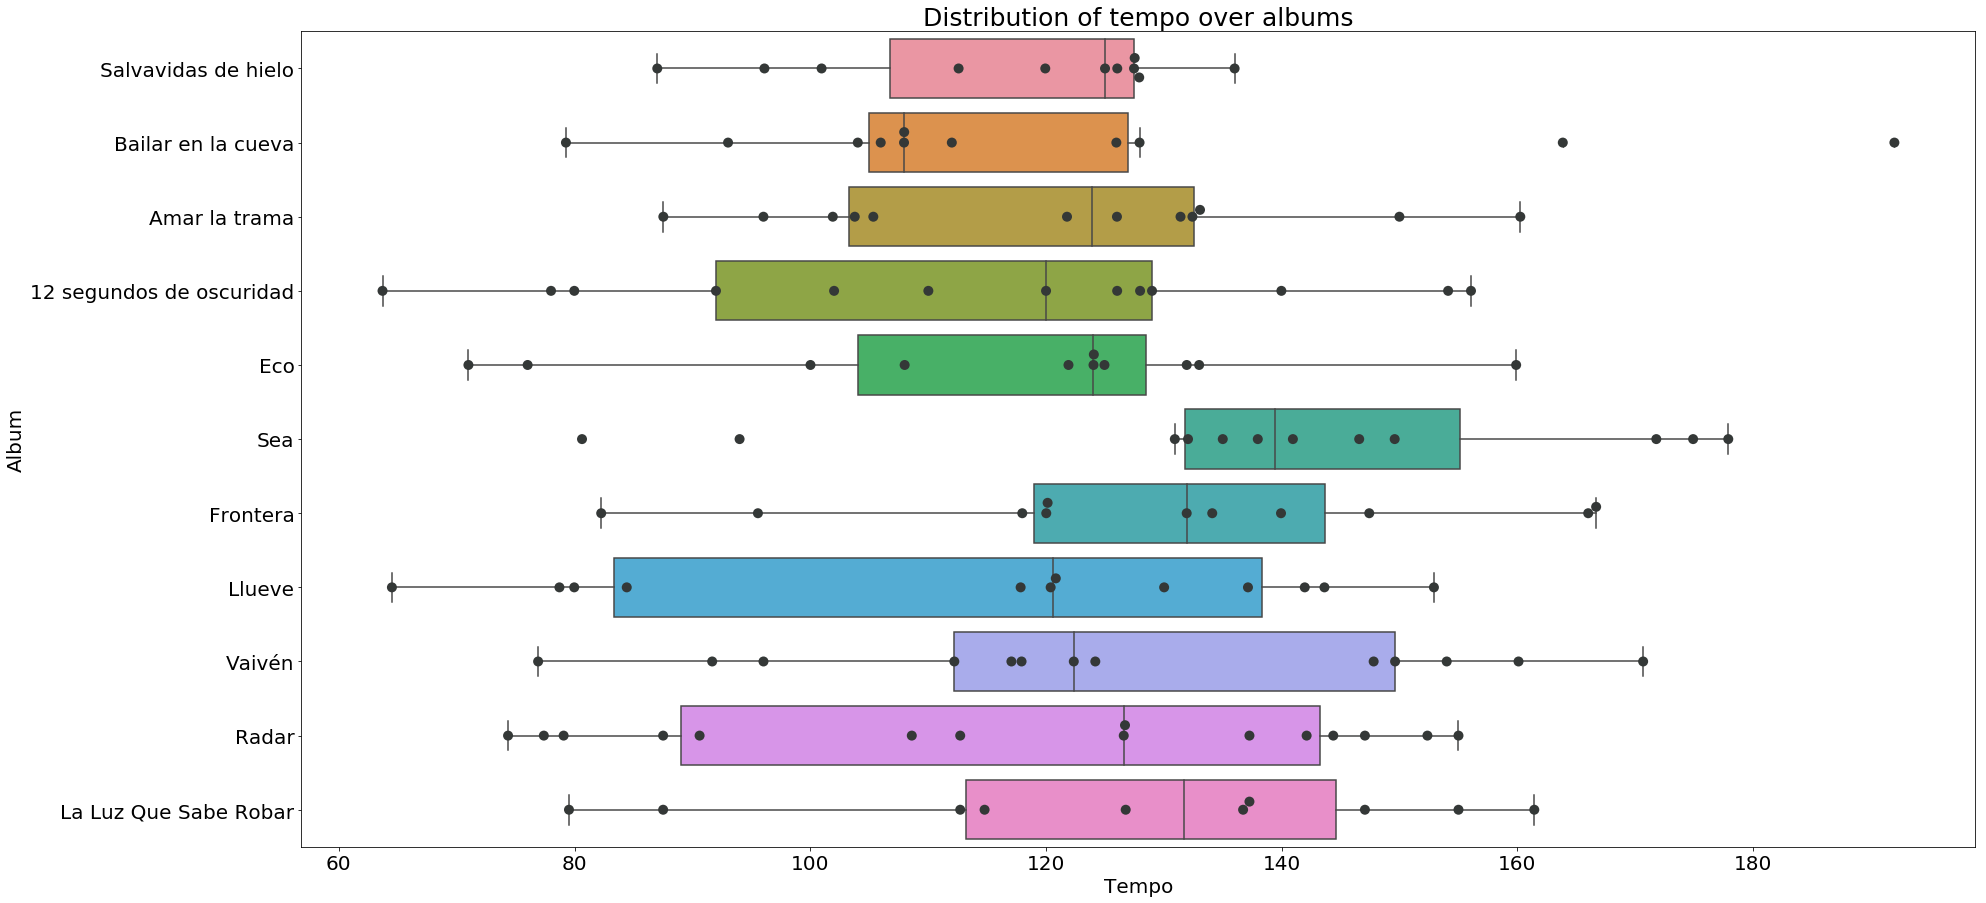

In [69]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="tempo", y="album", data=spoti_df, orient='h')
ax = sns.swarmplot(x="tempo", y="album", data=spoti_df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Tempo', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of tempo over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

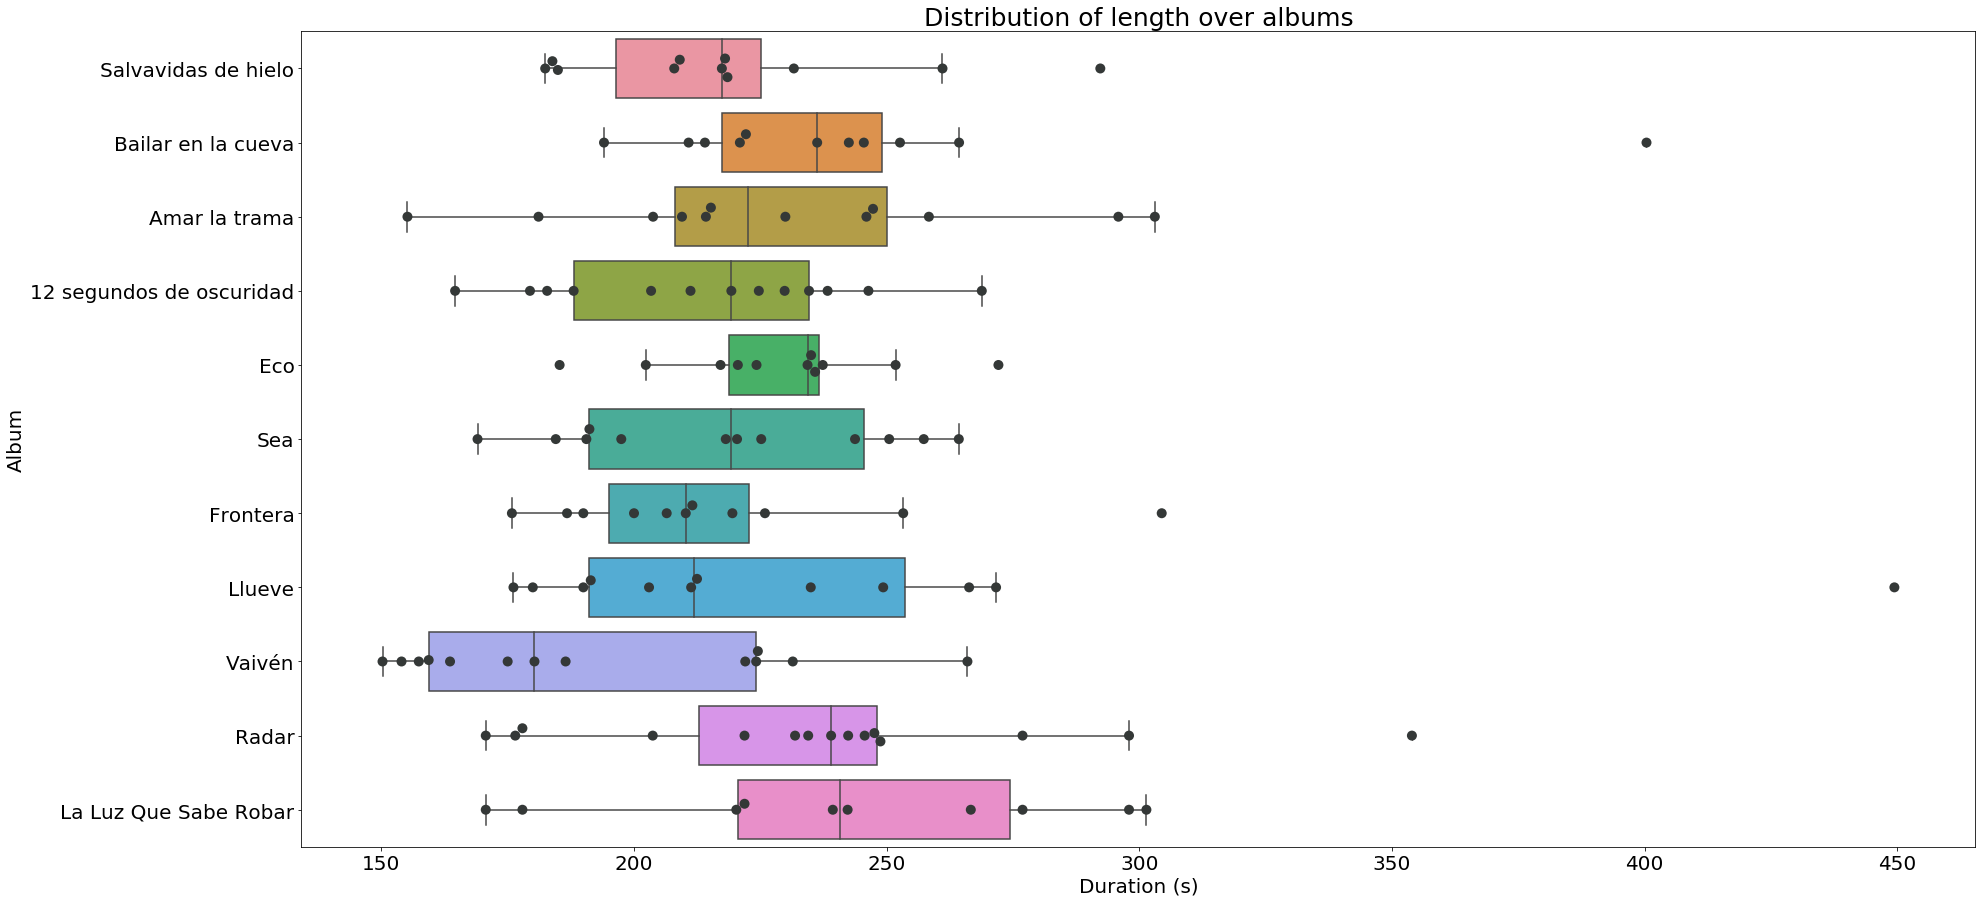

In [24]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.boxplot(x="duration_s", y="album", data=df, orient='h')
ax = sns.swarmplot(x="duration_s", y="album", data=df, orient='h', size=10, color="xkcd:charcoal")
plt.xlabel('Duration (s)', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of length over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.plot();

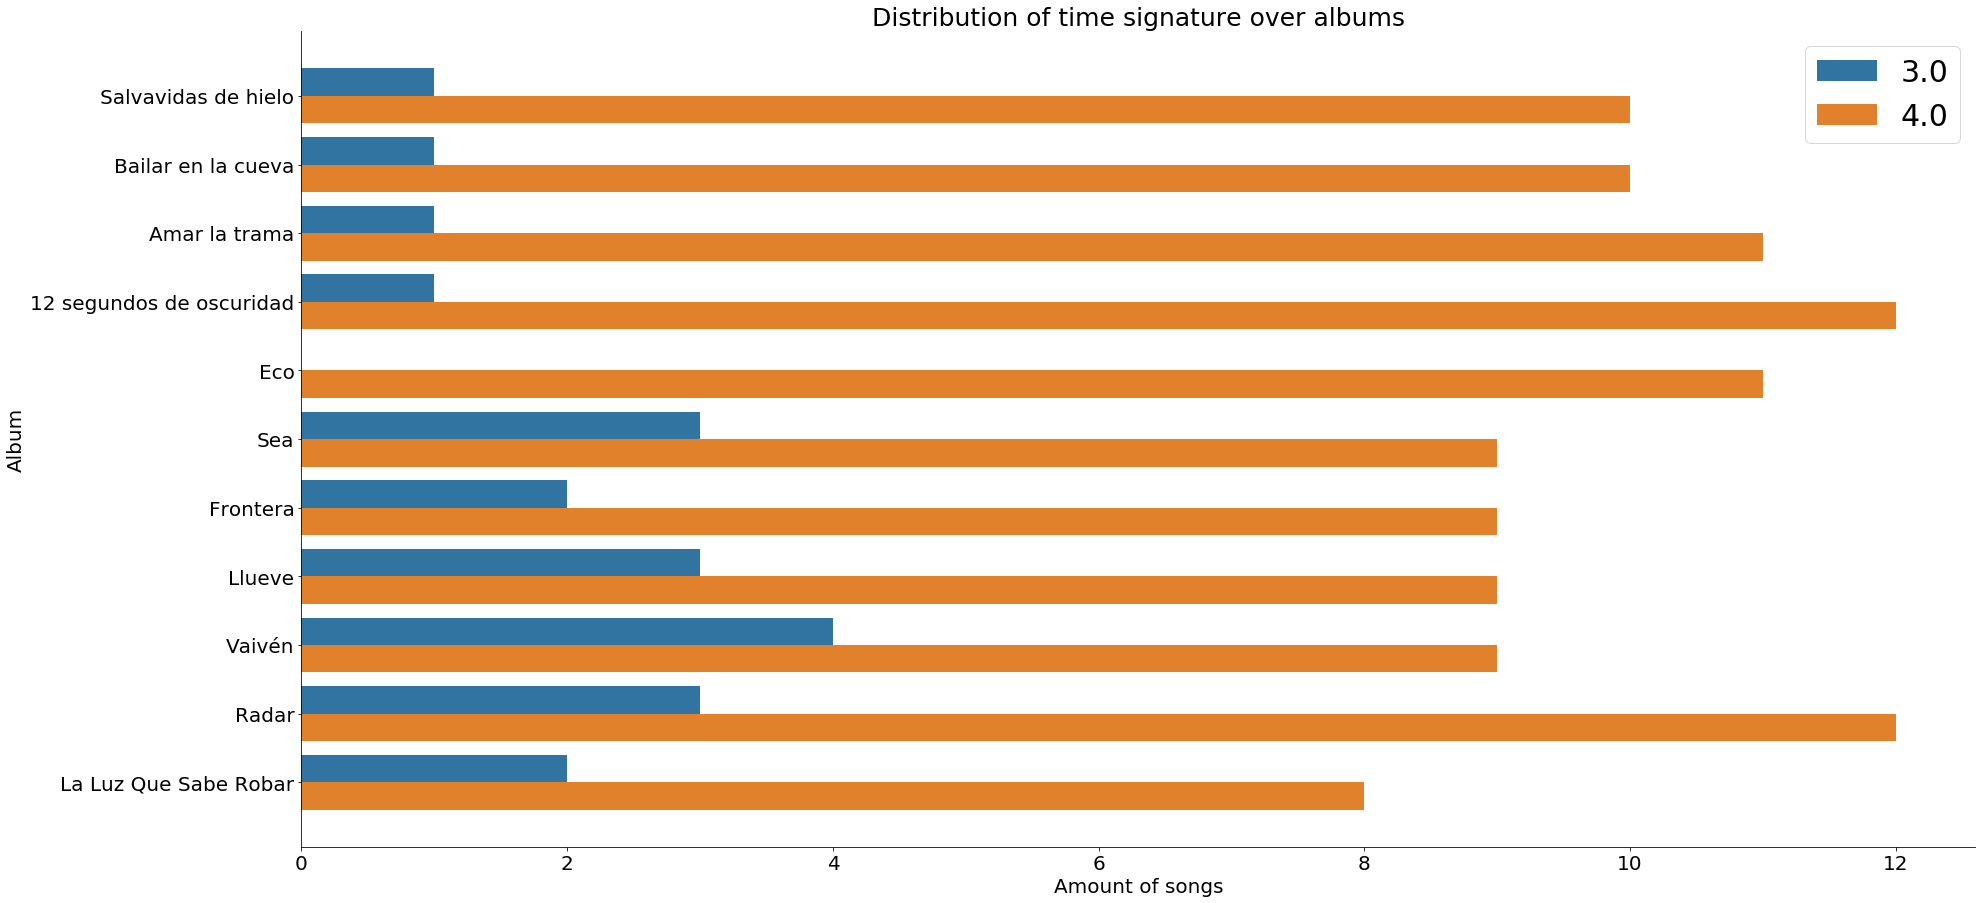

In [85]:
fig, ax = plt.subplots(figsize=(30,15))
ax = sns.countplot(y="album", orient='h', hue="time_signature", data=spoti_df)
plt.xlabel('Amount of songs', fontsize=20)
plt.ylabel('Album', fontsize=20)
plt.title('Distribution of time signature over albums', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
ax.legend(prop={'size': 30})
plt.plot();

### From spotify api
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

Let's make a real key feature

In [86]:
keymap = {0: 'C', 1: 'Db', 2: 'D', 3: 'Eb',
          4:'E', 5:'F', 6:'F#', 7:'G', 8:'Ab',
          9:'A', 10:'Bb', 11:'B'}

In [93]:
df['real_key'] = df.key.map(keymap)
for index, row in df.iterrows():
    if not row['mode']:
        df.at[index, 'real_key'] = row['real_key'] + 'm'        
        #Major is represented by 1 and minor is 0.

In [95]:
spoti_df['real_key'] = df['real_key']

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


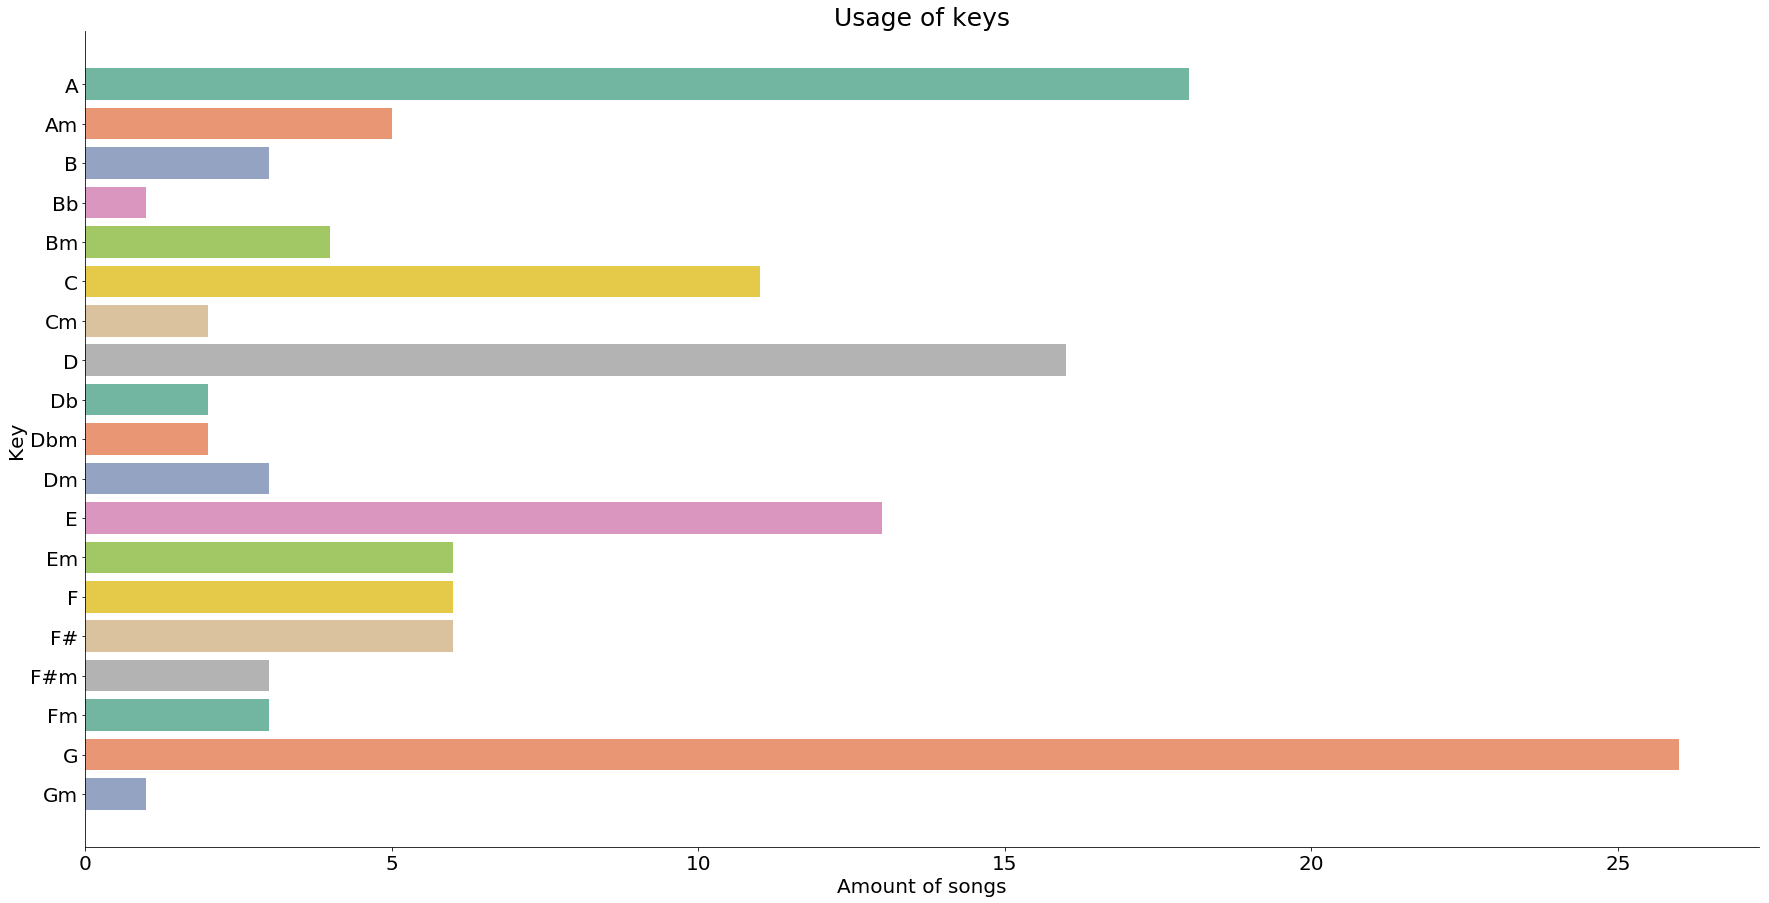

In [109]:
fig, ax = plt.subplots(figsize=(30,15))
order = sorted(spoti_df.real_key.unique())
ax = sns.countplot(y="real_key", orient='h', data=spoti_df, order=order, palette="Set2")
plt.xlabel('Amount of songs', fontsize=20)
plt.ylabel('Key', fontsize=20)
plt.title('Usage of keys', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();


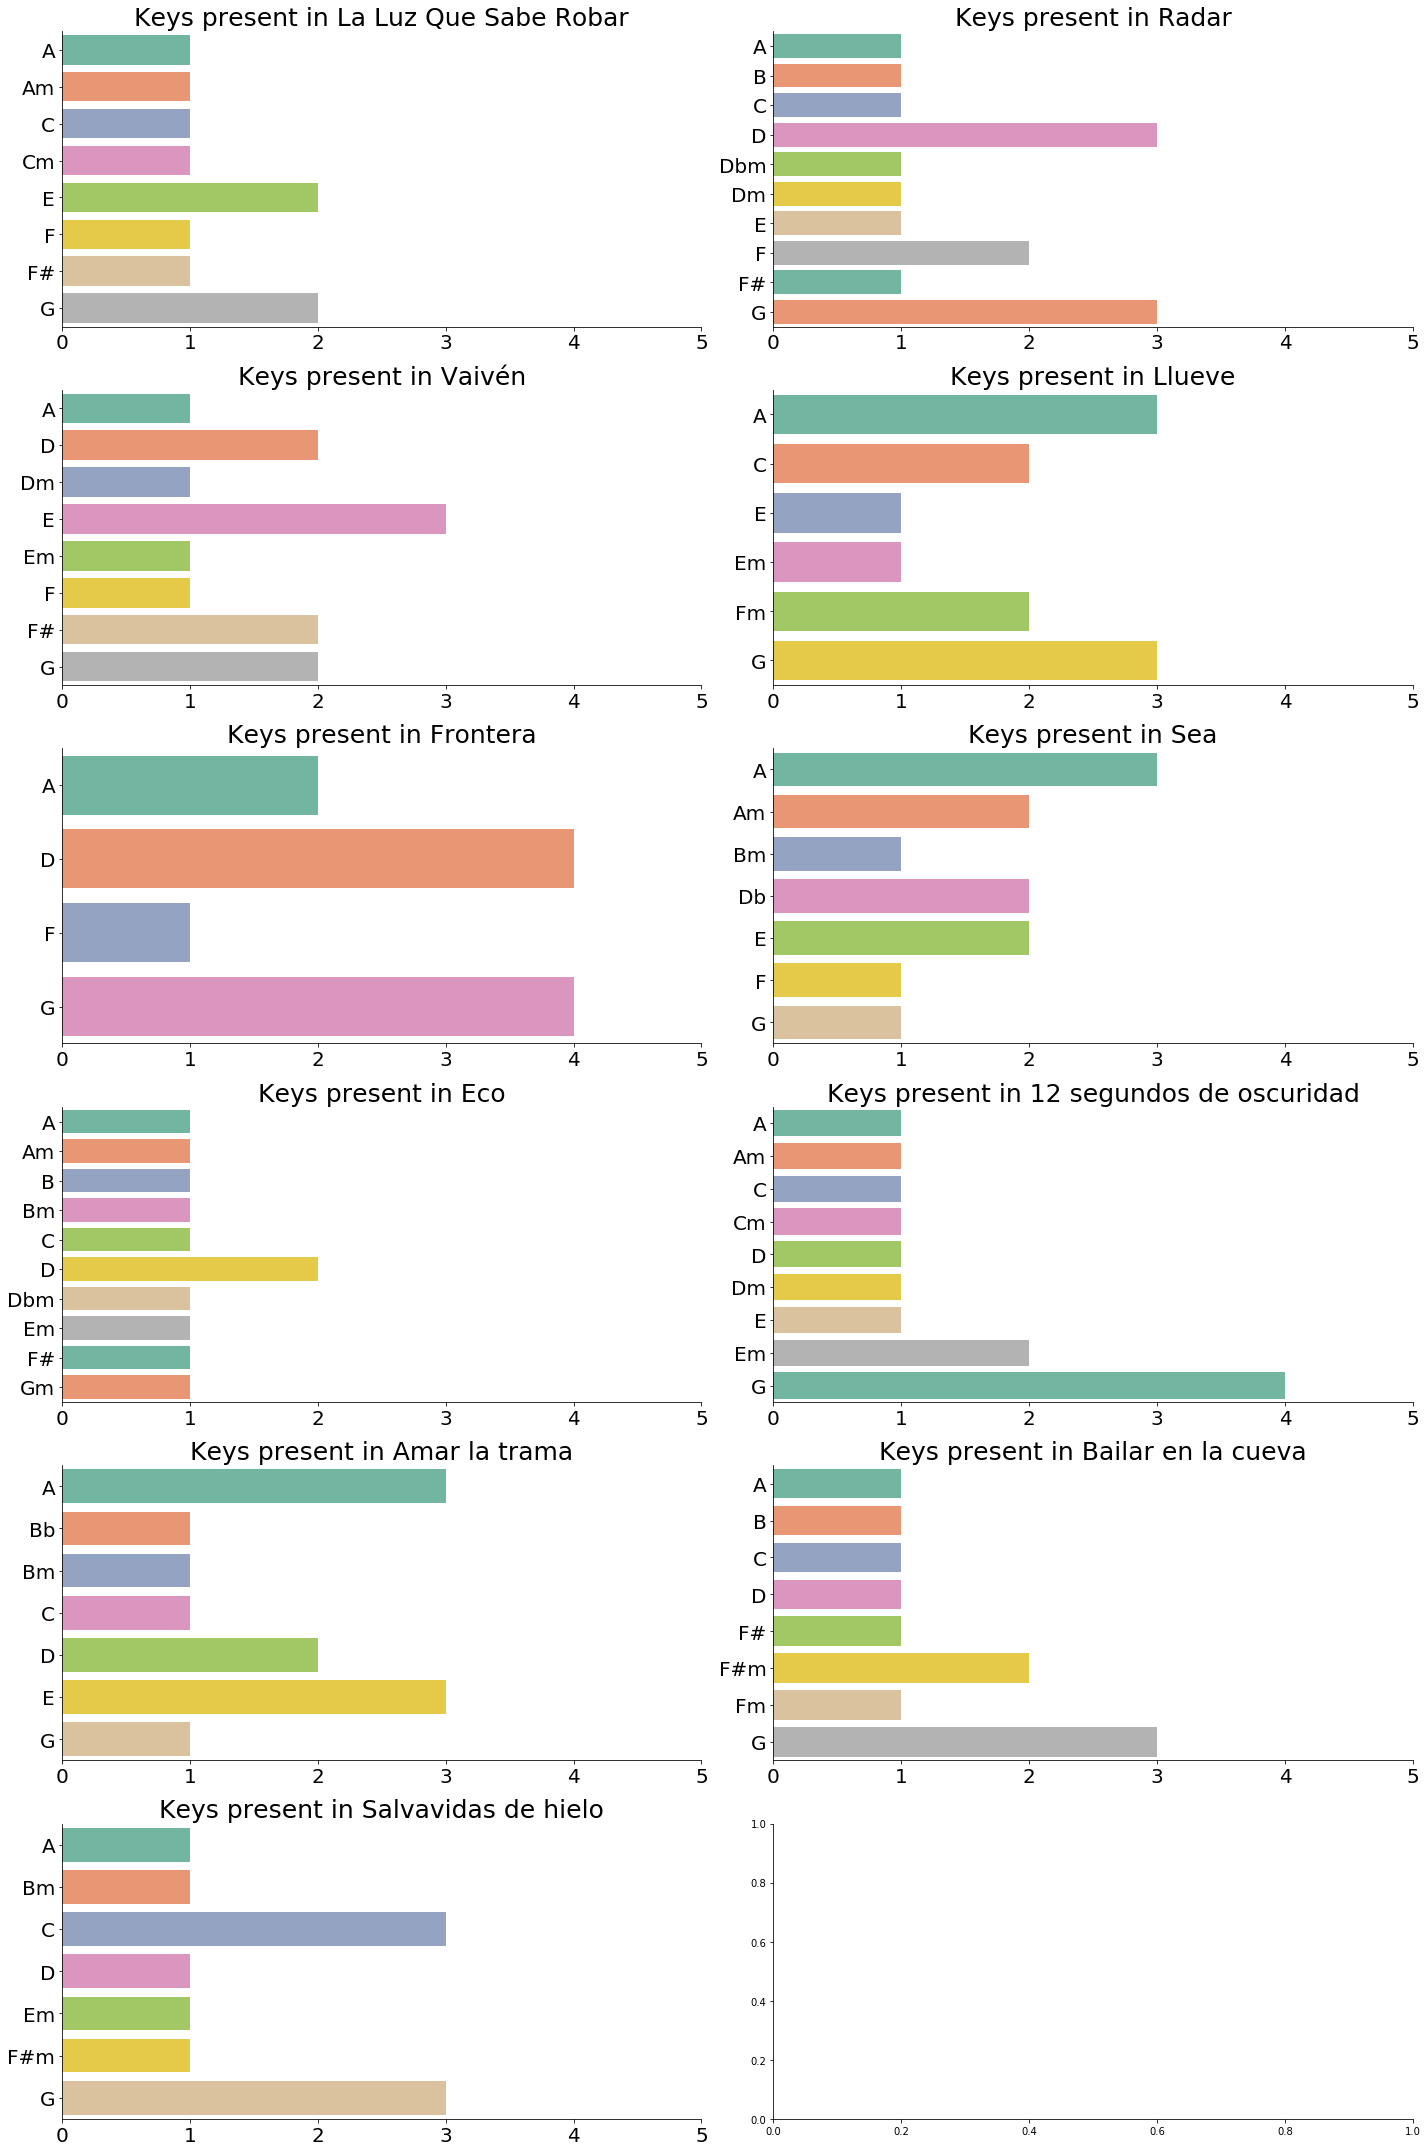

In [192]:
albums_ordered_by_year = [
    'La Luz Que Sabe Robar', 'Radar', 'Vaivén', 
    'Llueve', 'Frontera', 'Sea', 
    'Eco', '12 segundos de oscuridad','Amar la trama',
    'Bailar en la cueva', 'Salvavidas de hielo', ""
]

ROWS = 6
COLS = 2
cols_to_iterate = albums_ordered_by_year
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,30))
for row in range(ROWS):
    for col in range(COLS):
        an_album = cols_to_iterate.pop(0)
        if an_album == "":
            break
        key_by_album = pd.DataFrame(spoti_df[spoti_df['album'] == an_album])
        order = sorted(key_by_album.real_key.unique())
        ax = sns.countplot(y="real_key", orient='h', data=key_by_album, ax=axes[row, col], order=order, palette="Set2")
        
        axes[row, col].set_xticks([0,1,2,3,4,5])
        axes[row, col].set_title('Keys present in %s' % an_album, fontsize=25)
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)

        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")
        
sns.despine()
plt.tight_layout()
plt.show()


# Last step! Saddest and happiest song?

https://www.rcharlie.com/post/fitter-happier/

In [127]:
df.sort_values(by='valence', ascending=False).head()[['name', 'valence']]

,name,valence
index,,
100,Un Lugar En Tu Almohada,0.950
7,Mandato,0.937
61,Horas,0.924
60,Causa Y Efecto,0.920
4,Estalactitas,0.909


In [128]:
df.sort_values(by='valence').head()[['name', 'valence']]

,name,valence
index,,
34,12 segundos de oscuridad,0.0396
83,Llueve,0.0765
21,Organdí,0.1060
2,Silencio,0.1270
8,Despedir a los glaciares,0.1430


joy and sadness percentage

In [141]:
for index, row in df.iterrows():    
    try:
        to_lower = list(map(lambda x:x.lower(),df.loc[index].tokens))
        annotation = lexicon.annotate_doc(to_lower)
        count_sadness = 0
        count_joy = 0
        for a_set in annotation:
            if 'sadness' in a_set:
                count_sadness +=1
            if 'joy' in a_set:
                count_joy +=1
        df.at[index, 'sadness_per'] = count_sadness / len(annotation)        
        df.at[index, 'joy_per'] = count_joy / len(annotation)        
    except:
        continue

In [143]:
df.sort_values(by='sadness_per').head()[['name', 'sadness_per']]

,name,sadness_per
index,,
65,Me Haces Bien,0.0
51,Transporte,0.0
59,Sea,0.0
129,Macarena y el espejo,0.0
66,Durante,0.0


In [146]:
df.sort_values(by='sadness_per', ascending=False).head()[['name', 'sadness_per']]

,name,sadness_per
index,,
27,Toque de queda,0.127907
98,Ganas De Ti,0.116667
75,Madre Tierra,0.111111
61,Horas,0.108333
103,Dos Colores: Blanco Y Negro,0.103448


$$ gloom\_index = \frac{(1 - valence) + sadness\_per * (1 + ly_d)}{2}$$

In [177]:
df['gloom_index'] = ((1 - df['valence']) + df['sadness_per'] * (1 + df['ly_d']) ) / 2

In [179]:
# Create x, where x the 'scores' column's values as floats
x = df[['gloom_index']].fillna(0).values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,100))

# Create an object to transform the data to fit minmax processor
df['gloom_index'] = min_max_scaler.fit_transform(x)

In [175]:
df.sort_values(by='gloom_index', ascending=False).head()[['name', 'gloom_index']]

,name,gloom_index
index,,
34,12 segundos de oscuridad,100.000000
8,Despedir a los glaciares,86.083937
83,Llueve,85.760917
87,Cara B,85.351075
21,Organdí,84.602588


$$ brightness\_index = \frac{valence + joy\_per * (1 + ly_d)}{2}$$

In [180]:
df['brightness_index'] = (df['valence'] + df['joy_per'] * (1 + df['ly_d']) ) / 2

In [181]:
# Create x, where x the 'scores' column's values as floats
x = df[['brightness_index']].fillna(0).values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,100))

# Create an object to transform the data to fit minmax processor
df['brightness_index'] = min_max_scaler.fit_transform(x)

In [183]:
df.sort_values(by='brightness_index', ascending=False).head(6)[['name', 'brightness_index']]

,name,brightness_index
index,,
60,Causa Y Efecto,100.000000
100,Un Lugar En Tu Almohada,97.006432
116,Bienvenida,95.375151
121,Bienvenida,95.375151
68,Uno,94.783954
54,"Se va, se va, se fue",94.709498


Sources 


http://sigdelta.com/blog/text-analysis-in-pandas/

http://www.everydayanalytics.ca/2013/06/radiohead-lyrics-data-visualization-and-content-analysis.html
- https://www.promptcloud.com/blog/data-visualization-text-mining-taylor-swift-song-lyrics
